<a href="https://colab.research.google.com/github/adcaceres69/Proyecto-DENGUE/blob/main/Ent%233/ProyectoFinal_CACERES_2509.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ¿Se podría predecir la cantidad total de casos en una epidemia de Dengue?

El dengue es una enfermedad transmitida por mosquitos (Aedes aegypti) que se presenta en lugares con climas tropicales y subtropicales en el mundo.

La dinámica de transmisión de la enferemedad (dengue) está relacionada con variables climáticas como la temperatura y la precipitación.

En base a esto, se nos ha facilitado datos relacionados a dos ciudades, San Juan (Puerto Rico) e Iquitos (Peru), con datos de prueba para cada ciudad que abarcan 5 y 3 años respectivamente.

Los datos contenidos en el dataset son:
- Datos de ciudad y fechas (año; semanas)
- Indices de vegetación
- Precipitaciones totales
- Mediciones por reanálsis de pronósticos climáticos (precipitaciones; humedad el aire -relativa y específica-; temperaturas mínimas y máximas; rangos de temperaturas)
- Mediciones de estaciones meteorológicas

# Caracteristicas de los datos

Conjunto de información en una escala de tiempo (*year, weekofyear*):

Según corresponda, las unidades se proporcionan como un *_unit* como sufijo en el nombre del campo.

### Indicadores para ciudad y fecha
* *city*: Abreviaturas de ciudades: *sj* para San Juan y *sj* para Iquitos
* *week_start_date*: Fecha dada en formato aaaa-mm-dd

###Mediciones diarias de la estación meteorológica de datos climáticos GHCN de la NOAA:
* *station_max_temp_c*: Temperatura máxima
* *station_min_temp_c*: Temperatura mínima
* *station_avg_temp_c*: Temperatura media
* *station_precip_mm*: Precipitación total
* *station_diur_temp_rng_c*: Rango de temperatura diurna

###Mediciones de precipitación por satélite PERSIANN (escala de 0,25 x 0,25 grados):
* *precipitation_amt_mm*: Precipitación total

###Mediciones de reanálisis del sistema de pronóstico climático NCEP de la NOAA (escala de 0,5 x 0,5 grados):
* *reanalysis_sat_precip_amt_mm*: Precipitación total
* *reanalysis_dew_point_temp_k*: Temperatura media del punto de rocío
* *reanalysis_air_temp_k*: Temperatura media del aire
* *reanalysis_relative_humidity_percent*: Humedad relativa media
* *reanalysis_specific_humidity_g_per_kg*: Humedad específica media
* *reanalysis_precip_amt_kg_per_m2*: Precipitación total
* *reanalysis_max_air_temp_k*: Temperatura máxima del aire
* *reanalysis_min_air_temp_k*: Temperatura mínima del aire
* *reanalysis_avg_temp_k*: Temperatura media del aire
* *reanalysis_tdtr_k*: Rango de temperatura diurna

###Vegetación satelital - Índice de vegetación de diferencia normalizada (NDVI) - Mediciones del índice de vegetación de diferencia normalizada CDR de NOAA (escala de 0,5x0,5 grados):
* *ndvi_se*: Píxel al sureste del centroide de la ciudad
* *ndvi_sw*: Pixel al suroeste del centroide de la ciudad
* *ndvi_ne*: Píxel al noreste del centroide de la ciudad
* *ndvi_nw*: Pixel al noroeste del centroide de la ciudad

# Algunas Hipótesis
- Se supone la existencia de una relación entre los casos de Dengue y las precipitaciones, humedad, temperaturas, indice de vegetación.
- Se supone el crecimiento de casos por cambios climáticos a través de los años
- Se supone que predicciones precisas sobre la aparición de casos; ayudaría a los sistemas de salud a minimizar impactos

#OBJETIVOS

***Poder generar un modelo para predicción de Casos de Dengue en años venideros***

# Desarrollo del Proyecto

## Herramientas

In [ ]:
# librerías genéricas par tratar datos
import pandas as pd
import numpy as np

import scipy

# librerías gráficas
import matplotlib.pyplot as plt
import seaborn as sns

#importando clase PCA desde scikit-learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

# herramientas varias
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
from scipy.stats import shapiro

#import sklearn

### *Cargando datos*

In [ ]:
df_features = pd.read_csv('/dengue_features_train.csv') #dataset con características climáticas
df_label = pd.read_csv('/dengue_labels_train.csv') #dataset con casos de casos y otros por ciudad

Información preliminar

In [ ]:
# algunos datos de ejemplo
df_features.sample(5)

city  year  weekofyear week_start_date   ndvi_ne  ndvi_nw   ndvi_se  \
1234   iq  2006          12      2006-03-26  0.288567  0.17954  0.297271   
400    sj  1998           2      1998-01-08  0.050767  0.03410  0.223371   
344    sj  1996          50      1996-12-09       NaN  0.04950  0.155914   
163    sj  1993          24      1993-06-18       NaN  0.07850  0.220943   
929    sj  2008          11      2008-03-11 -0.321400 -0.14120  0.110643   

       ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
1234  0.223643                120.62             297.494286  ...   
400   0.134157                 10.59             298.827143  ...   
344   0.176000                  0.00             297.827143  ...   
163   0.219371                 30.65             299.184286  ...   
929   0.141014                  0.00             297.595714  ...   

      reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
1234                            70.00                             93.787143   
400                             44.40                             79.631429   
344                              3.80                             73.252857   
163                             55.50                             81.492857   
929                              9.38                             71.934286   

      reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
1234                        120.62                              17.911429   
400                          10.59                              16.362857   
344                           0.00                              14.245714   
163                          30.65                              17.130000   
929                           0.00                              13.721429   

      reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
1234           7.342857           27.400000                 8.700000   
400            2.157143           26.357143                 6.142857   
344            2.757143           24.800000                 6.571429   
163            2.100000           27.728571                 6.785714   
929            2.085714           25.328571                 5.814286   

      station_max_temp_c  station_min_temp_c  station_precip_mm  
1234                32.3                23.0               97.0  
400                 31.7                22.8               33.3  
344                 30.0                20.6                3.1  
163                 32.2                23.3               57.9  
929                 28.9                22.2                4.4  

[5 rows x 24 columns]

In [ ]:
# caracteristicas de las variables en "df_features"
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

In [ ]:
## algunos datos de ejemplo
df_label.sample(5)

city  year  weekofyear  total_cases
591   sj  2001          37           65
673   sj  2003          15            2
691   sj  2003          33           21
956   iq  2000          46            0
460   sj  1999           9           37

In [ ]:
## caracteristicas de las variables en "df_label"
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   city         1456 non-null   object
 1   year         1456 non-null   int64 
 2   weekofyear   1456 non-null   int64 
 3   total_cases  1456 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 45.6+ KB


In [ ]:
# Cantidad de filas y columnas en los dataset
print('El dataset "df_features" tiene ' + str(df_features.shape[0]) + ' filas, y ' + str(df_features.shape[1]) + ' columnas.')
print('El dataset "df_label" tiene ' + str(df_label.shape[0]) + ' filas, y ' + str(df_label.shape[1]) + ' columnas.')

El dataset "df_features" tiene 1456 filas, y 24 columnas.
El dataset "df_label" tiene 1456 filas, y 4 columnas.


In [ ]:
# Cantidad de ciudades distintas en el dataset de features
df_features.city.value_counts()

sj    936
iq    520
Name: city, dtype: int64

In [ ]:
# hacemos mas legibles los nombres de ciudades
df_features.replace("sj", "San Juan, PR", inplace=True)
df_features.replace("iq","Iquito, PE", inplace=True)
print('Ciudades diferentes:', df_features.city.unique())

Ciudades diferentes: ['San Juan, PR' 'Iquito, PE']


In [ ]:
# Algunos estadisticos por ciudad
df_features.groupby('city').describe()

year                                                           \
              count         mean       std     min      25%     50%      75%   
city                                                                           
Iquito, PE    520.0  2005.000000  2.918283  2000.0  2002.75  2005.0  2007.25   
San Juan, PR  936.0  1998.826923  5.212076  1990.0  1994.00  1999.0  2003.00   

                     weekofyear             ... station_min_temp_c        \
                 max      count       mean  ...                75%   max   
city                                        ...                            
Iquito, PE    2010.0      520.0  26.503846  ...               22.0  24.2   
San Juan, PR  2008.0      936.0  26.503205  ...               23.9  25.6   

             station_precip_mm                                            \
                         count       mean        std  min     25%    50%   
city                                                                       
Iquito, PE               504.0  62.467262  63.245958  0.0  17.200  45.30   
San Juan, PR             930.0  26.785484  29.325811  0.0   6.825  17.75   

                            
                75%    max  
city                        
Iquito, PE    85.95  543.3  
San Juan, PR  35.45  305.9  

[2 rows x 176 columns]

In [ ]:
# rango de tiempo en los datos
#print(df_features.year.unique())
print('Hay datos desde:', df_features.year.min(), 'hasta', df_features.year.max(), 'en el dataset')

Hay datos desde: 1990 hasta 2010 en el dataset


In [ ]:
# Buscando nulos
df_features.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [ ]:
df_label.isnull().sum()

city           0
year           0
weekofyear     0
total_cases    0
dtype: int64

*distribución de las variables númericas en df_features*

array([[<Axes: title={'center': 'ndvi_ne'}>,
        <Axes: title={'center': 'ndvi_nw'}>,
        <Axes: title={'center': 'ndvi_se'}>,
        <Axes: title={'center': 'ndvi_sw'}>],
       [<Axes: title={'center': 'precipitation_amt_mm'}>,
        <Axes: title={'center': 'reanalysis_air_temp_k'}>,
        <Axes: title={'center': 'reanalysis_avg_temp_k'}>,
        <Axes: title={'center': 'reanalysis_dew_point_temp_k'}>],
       [<Axes: title={'center': 'reanalysis_max_air_temp_k'}>,
        <Axes: title={'center': 'reanalysis_min_air_temp_k'}>,
        <Axes: title={'center': 'reanalysis_precip_amt_kg_per_m2'}>,
        <Axes: title={'center': 'reanalysis_relative_humidity_percent'}>],
       [<Axes: title={'center': 'reanalysis_sat_precip_amt_mm'}>,
        <Axes: title={'center': 'reanalysis_specific_humidity_g_per_kg'}>,
        <Axes: title={'center': 'reanalysis_tdtr_k'}>,
        <Axes: title={'center': 'station_avg_temp_c'}>],
       [<Axes: title={'center': 'station_diur_temp_rng

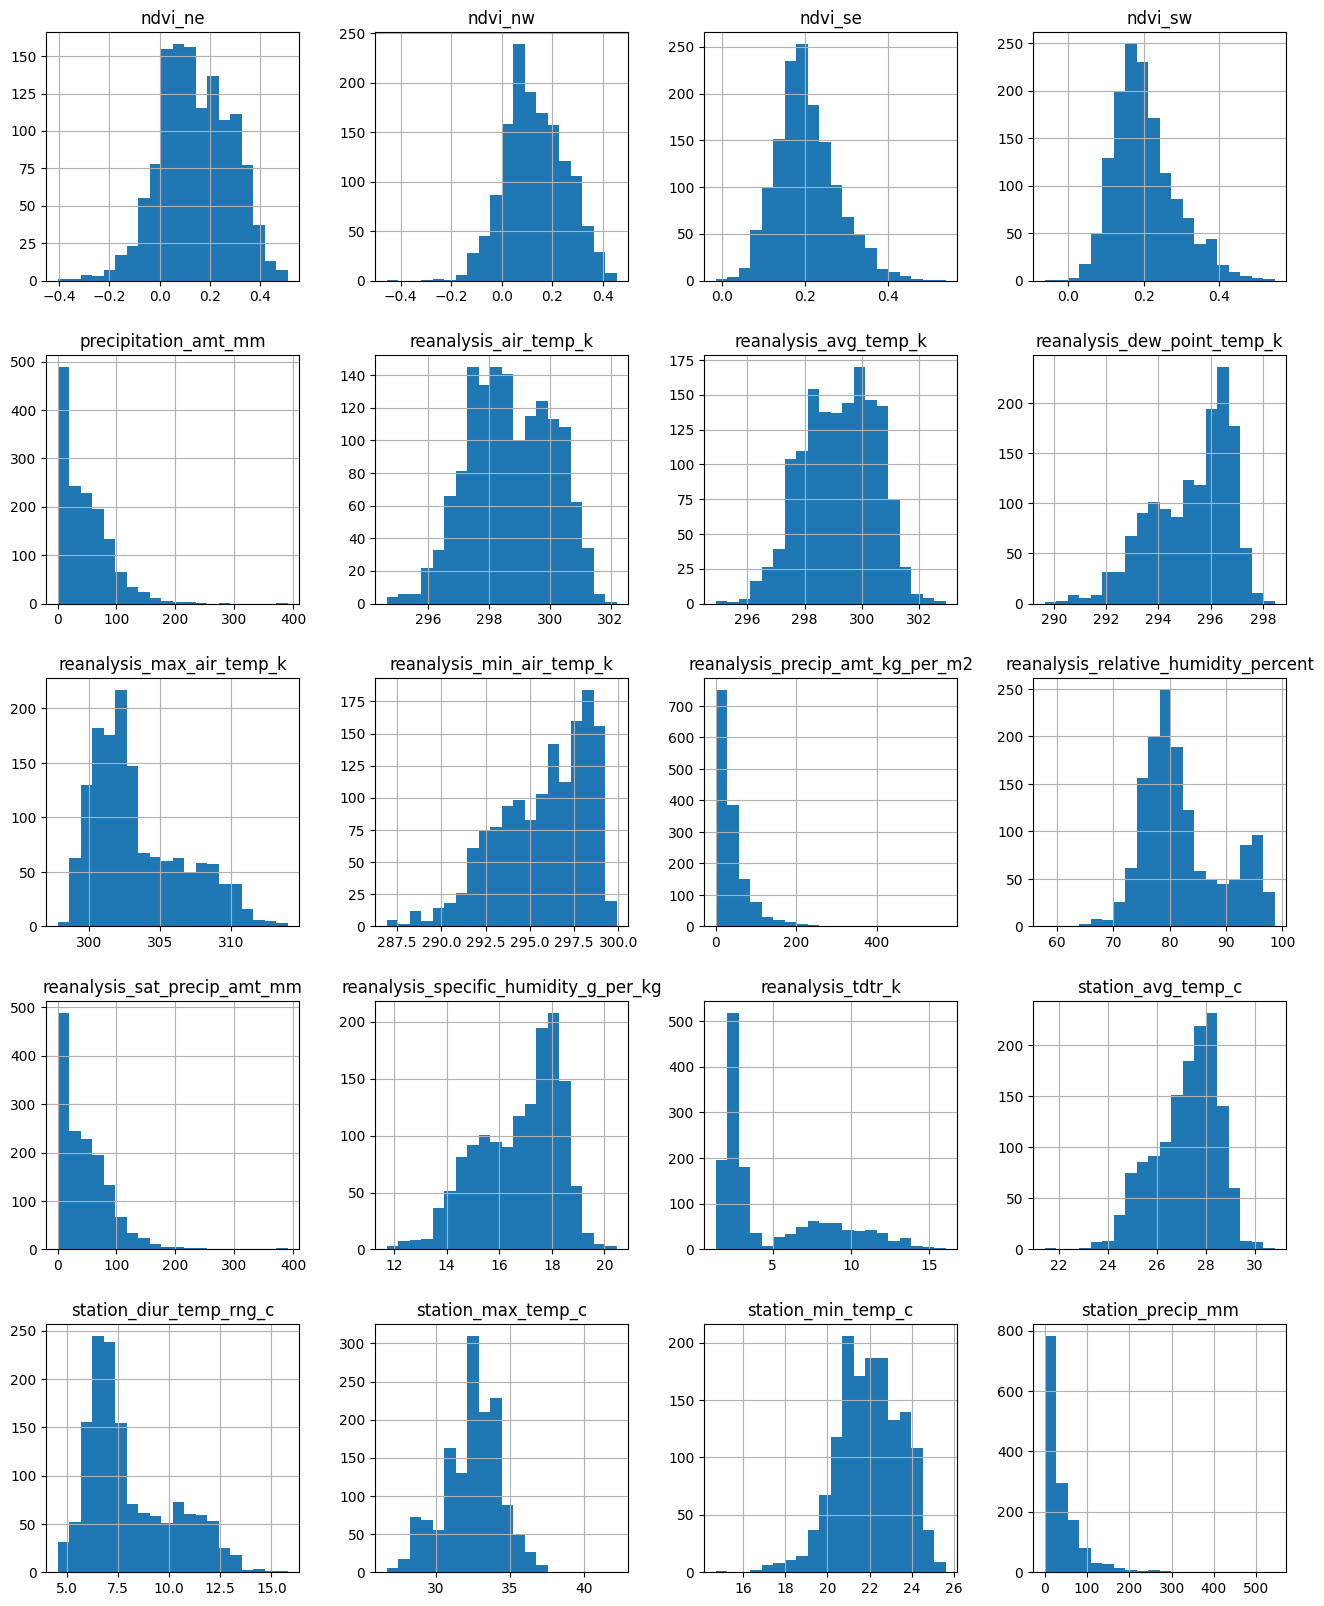

In [ ]:
# excluyo las primeras 4 columnas para un histograma
(df_features[df_features.columns[4:]]).hist(figsize=(16,20), bins=20)

*correlación entre variables númericas*

In [ ]:
# correlacion de las variables en "df_features"
(df_features[df_features.columns[4:]]).corr()

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
ndvi_ne                                1.000000  0.850902  0.614380  0.669504   
ndvi_nw                                0.850902  1.000000  0.555809  0.651938   
ndvi_se                                0.614380  0.555809  1.000000  0.820924   
ndvi_sw                                0.669504  0.651938  0.820924  1.000000   
precipitation_amt_mm                   0.205736  0.193563  0.074633  0.124047   
reanalysis_air_temp_k                 -0.340976 -0.317862 -0.157447 -0.227824   
reanalysis_avg_temp_k                 -0.037682 -0.030974  0.051348  0.022533   
reanalysis_dew_point_temp_k            0.056077  0.063289  0.002810  0.020746   
reanalysis_max_air_temp_k              0.634330  0.606775  0.468054  0.546460   
reanalysis_min_air_temp_k             -0.623116 -0.588806 -0.407931 -0.494284   
reanalysis_precip_amt_kg_per_m2        0.199411  0.190989  0.034792  0.101652   
reanalysis_relative_humidity_percent   0.457985  0.449152  0.215606  0.311759   
reanalysis_sat_precip_amt_mm           0.205736  0.193563  0.074633  0.124047   
reanalysis_specific_humidity_g_per_kg  0.094852  0.100626  0.028795  0.053437   
reanalysis_tdtr_k                      0.673935  0.645596  0.486047  0.569554   
station_avg_temp_c                     0.186227  0.203975  0.089242  0.121060   
station_diur_temp_rng_c                0.658129  0.649483  0.449599  0.545899   
station_max_temp_c                     0.491922  0.490122  0.290691  0.377393   
station_min_temp_c                    -0.315696 -0.304206 -0.251621 -0.294684   
station_precip_mm                      0.242263  0.221314  0.131326  0.158345   

                                       precipitation_amt_mm  \
ndvi_ne                                            0.205736   
ndvi_nw                                            0.193563   
ndvi_se                                            0.074633   
ndvi_sw                                            0.124047   
precipitation_amt_mm                               1.000000   
reanalysis_air_temp_k                             -0.017229   
reanalysis_avg_temp_k                              0.106384   
reanalysis_dew_point_temp_k                        0.434722   
reanalysis_max_air_temp_k                          0.282721   
reanalysis_min_air_temp_k                         -0.119691   
reanalysis_precip_amt_kg_per_m2                    0.481159   
reanalysis_relative_humidity_percent               0.499984   
reanalysis_sat_precip_amt_mm                       1.000000   
reanalysis_specific_humidity_g_per_kg              0.451202   
reanalysis_tdtr_k                                  0.201427   
station_avg_temp_c                                 0.225408   
station_diur_temp_rng_c                            0.193358   
station_max_temp_c                                 0.296215   
station_min_temp_c                                 0.076680   
station_precip_mm                                  0.486637   

                                       reanalysis_air_temp_k  \
ndvi_ne                                            -0.340976   
ndvi_nw                                            -0.317862   
ndvi_se                                            -0.157447   
ndvi_sw                                            -0.227824   
precipitation_amt_mm                               -0.017229   
reanalysis_air_temp_k                               1.000000   
reanalysis_avg_temp_k                               0.901777   
reanalysis_dew_point_temp_k                         0.529771   
reanalysis_max_air_temp_k                          -0.001211   
reanalysis_min_air_temp_k                           0.736765   
reanalysis_precip_amt_kg_per_m2                    -0.128219   
reanalysis_relative_humidity_percent               -0.402338   
reanalysis_sat_precip_amt_mm                       -0.017229   
reanalysis_specific_humidity_g_per_kg               0.508380   
reanalysis_tdtr_k                                  -0.

*observaciones sobre los datos faltantaes*

<Axes: >

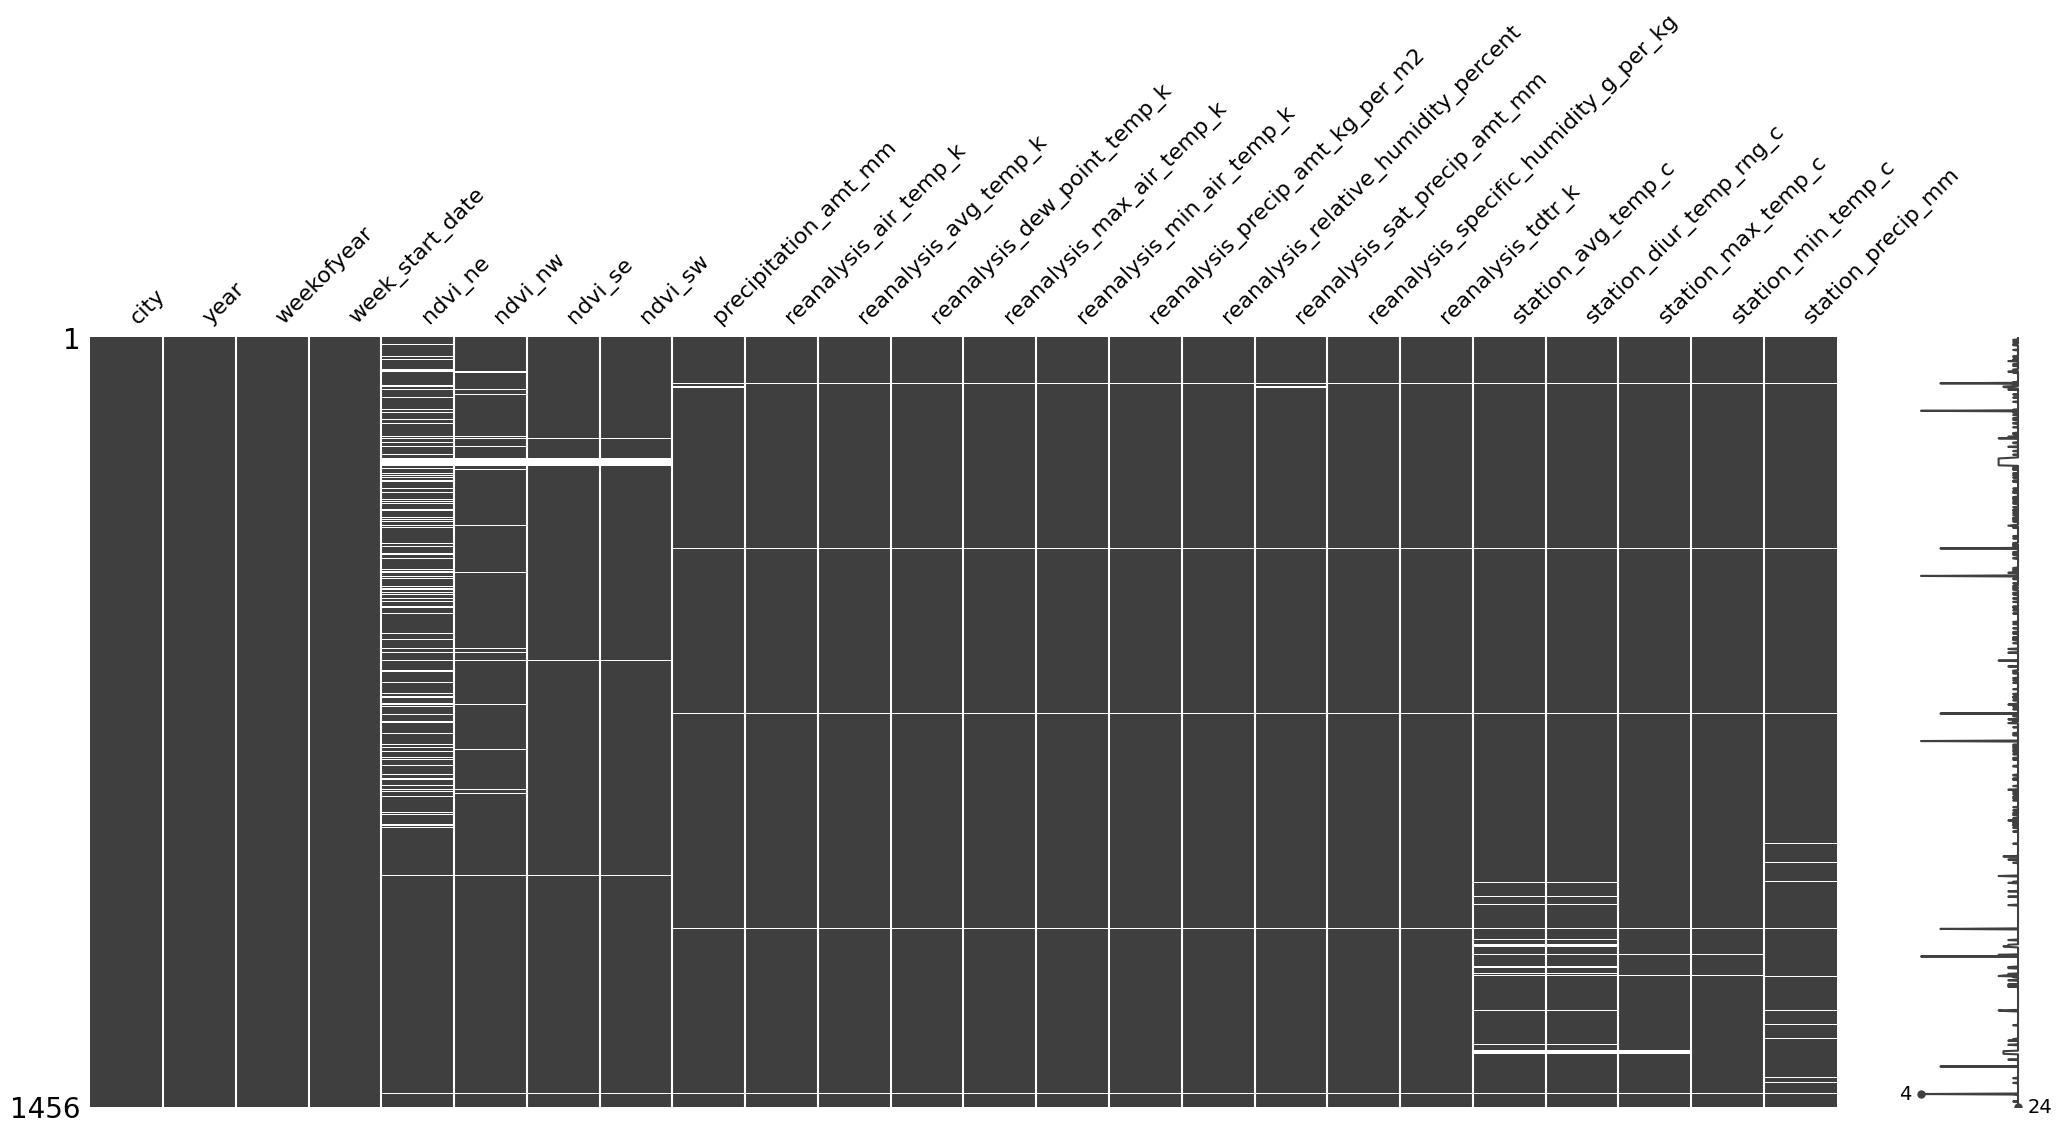

In [ ]:
#La función matrix de Missingno permite ver de una forma visual dónde se encuentran los valores nulos en un conjunto de datos.
import missingno as msno
msno.matrix(df_features)

In [ ]:
# analsis de la incidencia de esos datos faltantes en el total de datos

def missing_values_table(df_features):
        # Total de valores nulos
        mis_val = df_features.isnull().sum()

        # Porcentaje de valores nulos
        mis_val_percent = 100 * df_features.isnull().sum() / len(df_features)

        # Tabla de resultados
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Renombrando columnas
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valores_Nulos', 1 : '% Total_de_valores'})

        # Ordeno la nueva tabla por % descendentes
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% Total_de_valores', ascending=False).round(1)

        # Mostrando información general
        print ("El dataframe seleccionado tiene " + str(df_features.shape[1]) + " columnas.\n"
            "Hay " + str(mis_val_table_ren_columns.shape[0]) +
              " columnas con valores nulos.")

        # Devoluelve el dataframe con la información de nulos
        return mis_val_table_ren_columns

In [ ]:
# tabla de valores nulos
df_nulos= missing_values_table(df_features)
df_nulos

El dataframe seleccionado tiene 24 columnas.
Hay 20 columnas con valores nulos.


Valores_Nulos  % Total_de_valores
ndvi_ne                                          194                13.3
ndvi_nw                                           52                 3.6
station_diur_temp_rng_c                           43                 3.0
station_avg_temp_c                                43                 3.0
station_precip_mm                                 22                 1.5
ndvi_sw                                           22                 1.5
ndvi_se                                           22                 1.5
station_max_temp_c                                20                 1.4
station_min_temp_c                                14                 1.0
precipitation_amt_mm                              13                 0.9
reanalysis_sat_precip_amt_mm                      13                 0.9
reanalysis_air_temp_k                             10                 0.7
reanalysis_avg_temp_k                             10                 0.7
reanalysis_dew_point_temp_k                       10                 0.7
reanalysis_max_air_temp_k                         10                 0.7
reanalysis_min_air_temp_k                         10                 0.7
reanalysis_relative_humidity_percent              10                 0.7
reanalysis_specific_humidity_g_per_kg             10                 0.7
reanalysis_tdtr_k                                 10                 0.7
reanalysis_precip_amt_kg_per_m2                   10                 0.7

*la variable "ndvi_ne" posee un 13.3% de valores nulos y una correlación importante con "ndvi_nw"*

In [ ]:
# aqui adoptare un enfoque simple y reemplazare los valores nulos con el valor mas reciente
df_features_sn = df_features.fillna(method='ffill', inplace=True)

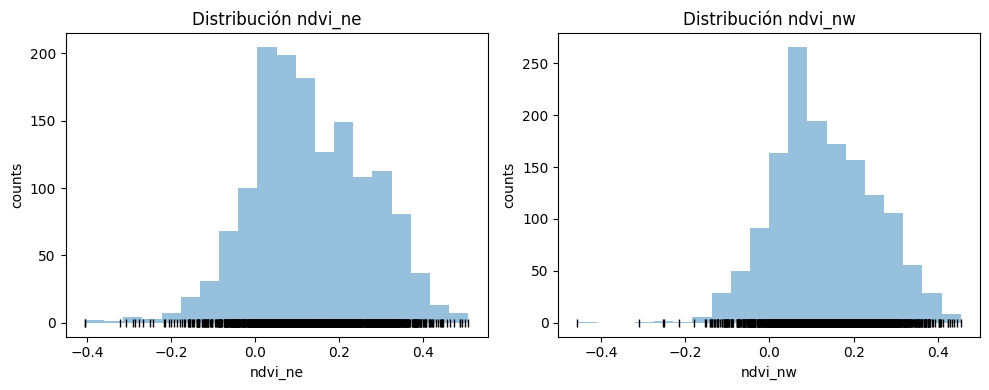

In [ ]:
#verficando normalidad de las variables testimoniales
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].hist(x=df_features.ndvi_ne, bins=20, color="#3182bd", alpha=0.5)
axs[0].plot(df_features.ndvi_ne, np.full_like(df_features.ndvi_ne, -0.01), '|k', markeredgewidth=1)
axs[0].set_title('Distribución ndvi_ne')
axs[0].set_xlabel('ndvi_ne')
axs[0].set_ylabel('counts')

axs[1].hist(x=df_features.ndvi_nw, bins=20, color="#3182bd", alpha=0.5)
axs[1].plot(df_features.ndvi_nw, np.full_like(df_features.ndvi_nw, -0.01), '|k', markeredgewidth=1)
axs[1].set_title('Distribución ndvi_nw')
axs[1].set_xlabel('ndvi_nw')
axs[1].set_ylabel('counts')


plt.tight_layout();

* distribución normal (prácticamente)
* observamos los valores estadísticos de correlación lineal
* obtenemos valores de intercepto y pendiente de correlación entre "ndvi_ne" y "ndvi_nw"

In [ ]:
# correlación de spearman
r, p = stats.spearmanr(df_features['ndvi_ne'], df_features['ndvi_nw'], nan_policy='omit')
print(f"Correlación Spearman: r={r}, p-value={p}")

Correlación Spearman: r=0.8457619586281172, p-value=0.0


In [ ]:
# El modelo no permite el calculo con valores NAN, los que fueron reemplazados

result = scipy.stats.linregress(df_features['ndvi_nw'], df_features['ndvi_ne'])

print("El coeficiente de correlación entre ndvi_ne y ndvi_nw es", result.rvalue)
print("La pendiente de la recta es:", result.slope)
print("El intercepto de la recta es:", result.intercept)
# En una línea de regresión, cuanto menor es el error estándar de la estimación, más precisas son las predicciones.
print ("El error estandar es: ", result.stderr)

El coeficiente de correlación entre ndvi_ne y ndvi_nw es 0.8241068586190434
La pendiente de la recta es: 0.9548353451904689
El intercepto de la recta es: 0.008987873864409163
El error estandar es:  0.017211247343152776


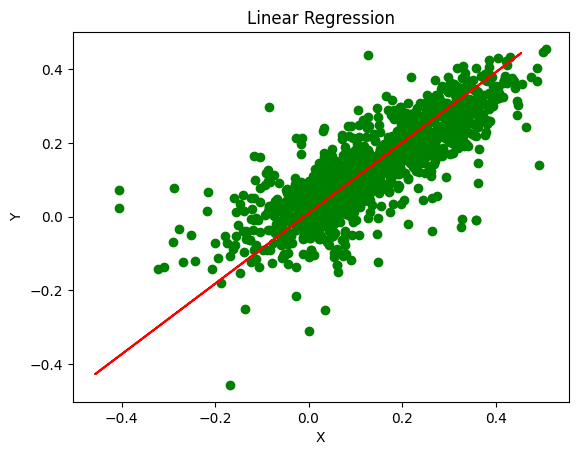

In [ ]:
a=result.slope
b=result.intercept
x=df_features['ndvi_nw']
y= result.slope*x +b

plt.scatter(df_features['ndvi_ne'],df_features['ndvi_nw'],color="green")
plt.plot(x,y,color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Linear Regression")
plt.show()

In [ ]:
# tabla de valores nulos
df_nulos1= missing_values_table(df_features)
df_nulos1

El dataframe seleccionado tiene 24 columnas.
Hay 0 columnas con valores nulos.


Empty DataFrame
Columns: [Valores_Nulos, % Total_de_valores]
Index: []

*uniremos los dataset de "features" (caracteristicas) con "label" (casos)*

In [ ]:
# dataset total de casos
df_label_tc = df_label.total_cases

In [ ]:
# dataset unificado con cantidad de casos
data_f = pd.concat([df_features, df_label_tc], axis=1)

In [ ]:
data_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1456 non-null   float64
 5   ndvi_nw                                1456 non-null   float64
 6   ndvi_se                                1456 non-null   float64
 7   ndvi_sw                                1456 non-null   float64
 8   precipitation_amt_mm                   1456 non-null   float64
 9   reanalysis_air_temp_k                  1456 non-null   float64
 10  reanalysis_avg_temp_k                  1456 non-null   float64
 11  rean

In [ ]:
data_f.sample(5)

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw  \
554  San Juan, PR  2000          51      2000-12-23  0.063200  0.046750   
329  San Juan, PR  1996          35      1996-08-26  0.012033  0.073967   
268  San Juan, PR  1995          25      1995-06-25  0.221350  0.217400   
439  San Juan, PR  1998          41      1998-10-08 -0.002200 -0.019000   
847  San Juan, PR  2006          32      2006-08-13  0.001740  0.013600   

      ndvi_se   ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
554  0.044600 -0.063457                  0.00             298.581429  ...   
329  0.298186  0.312600                 15.74             299.945714  ...   
268  0.219971  0.192043                 26.56             300.115714  ...   
439  0.163057  0.149200                 33.26             300.712857  ...   
847  0.145743  0.130986                 63.83             300.208571  ...   

     reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
554                             76.525714                          0.00   
329                             79.272857                         15.74   
268                             81.340000                         26.56   
439                             79.998571                         33.26   
847                             80.654286                         63.83   

     reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
554                              15.462857           1.714286   
329                              17.422857           2.557143   
268                              18.052857           2.000000   
439                              18.418571           2.342857   
847                              18.007143           2.857143   

     station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
554           25.385714                 5.542857                28.9   
329           27.757143                 6.214286                33.3   
268           28.842857                 7.371429                33.3   
439           28.257143                 5.500000                31.7   
847           27.442857                 5.400000                31.1   

     station_min_temp_c  station_precip_mm  total_cases  
554                21.7               63.2           22  
329                23.9               22.6           21  
268                24.4               10.5           10  
439                24.4               25.0          127  
847                23.9               40.9           10  

[5 rows x 25 columns]

## ANALISIS UNIVARIADO

In [ ]:
# revisando los tipos de datos
for i in data_f.columns:
  print('Para la columna "',i,'" el tipo de dato asociado es ',data_f[i].dtype)

Para la columna " city " el tipo de dato asociado es  object
Para la columna " year " el tipo de dato asociado es  int64
Para la columna " weekofyear " el tipo de dato asociado es  int64
Para la columna " week_start_date " el tipo de dato asociado es  object
Para la columna " ndvi_ne " el tipo de dato asociado es  float64
Para la columna " ndvi_nw " el tipo de dato asociado es  float64
Para la columna " ndvi_se " el tipo de dato asociado es  float64
Para la columna " ndvi_sw " el tipo de dato asociado es  float64
Para la columna " precipitation_amt_mm " el tipo de dato asociado es  float64
Para la columna " reanalysis_air_temp_k " el tipo de dato asociado es  float64
Para la columna " reanalysis_avg_temp_k " el tipo de dato asociado es  float64
Para la columna " reanalysis_dew_point_temp_k " el tipo de dato asociado es  float64
Para la columna " reanalysis_max_air_temp_k " el tipo de dato asociado es  float64
Para la columna " reanalysis_min_air_temp_k " el tipo de dato asociado es  fl

In [ ]:
# cambiando algunos tipos de datos
data_f['year']                                  = pd.to_numeric(data_f['year']);
data_f['weekofyear']                            = pd.to_numeric(data_f['weekofyear']);
data_f['week_start_date']                       = pd.to_datetime(data_f['week_start_date']);

In [ ]:
data_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1456 non-null   object        
 1   year                                   1456 non-null   int64         
 2   weekofyear                             1456 non-null   int64         
 3   week_start_date                        1456 non-null   datetime64[ns]
 4   ndvi_ne                                1456 non-null   float64       
 5   ndvi_nw                                1456 non-null   float64       
 6   ndvi_se                                1456 non-null   float64       
 7   ndvi_sw                                1456 non-null   float64       
 8   precipitation_amt_mm                   1456 non-null   float64       
 9   reanalysis_air_temp_k                  1456 non-null   float64 

In [ ]:
# Cantidad de datos por ciudad
data_f.city.value_counts()

San Juan, PR    936
Iquito, PE      520
Name: city, dtype: int64

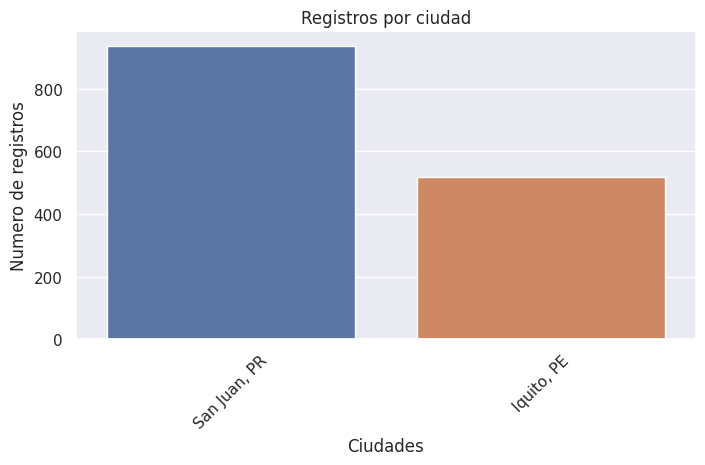

In [ ]:
#
plt.figure(figsize=(8,4))
sns.set_theme(style="darkgrid")
sns.countplot(data=data_f, x='city')

plt.title('Registros por ciudad')
plt.ylabel('Numero de registros')
plt.xlabel('Ciudades')
plt.xticks(rotation = 45)
plt.show();

*mayor cantidad de registros para San Juan de Puerto Rico*

<Axes: xlabel='year', ylabel='total_cases'>

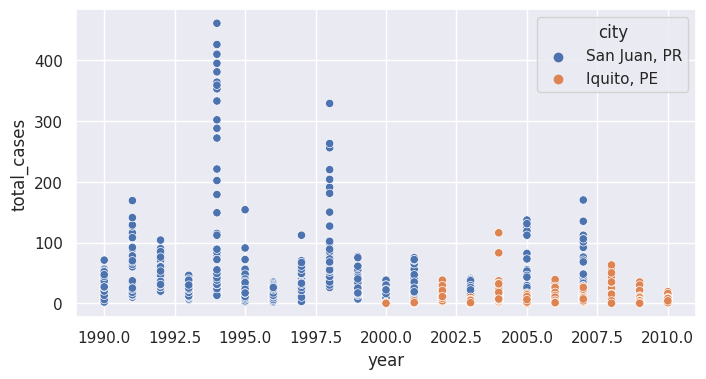

In [ ]:
#
plt.figure(figsize=(8,4))
sns.scatterplot(x=data_f.year, y=data_f['total_cases'], hue=data_f['city'])

*analisis una por una de todas las variables*

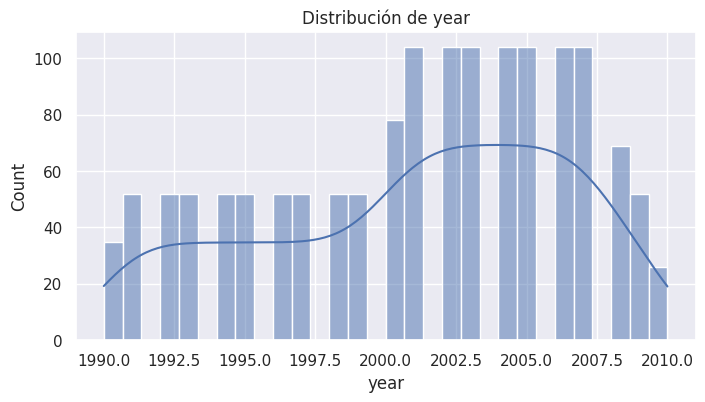

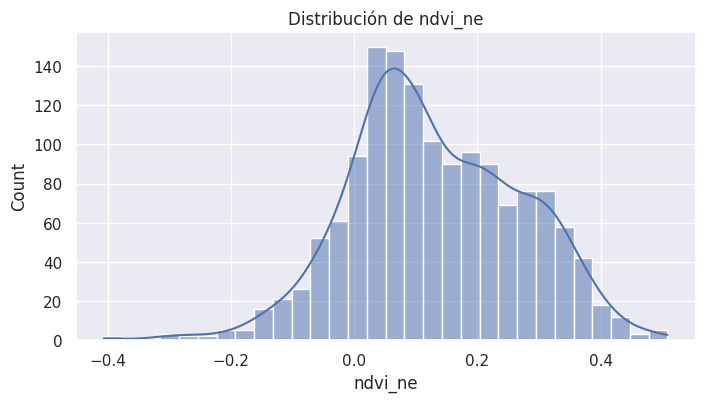

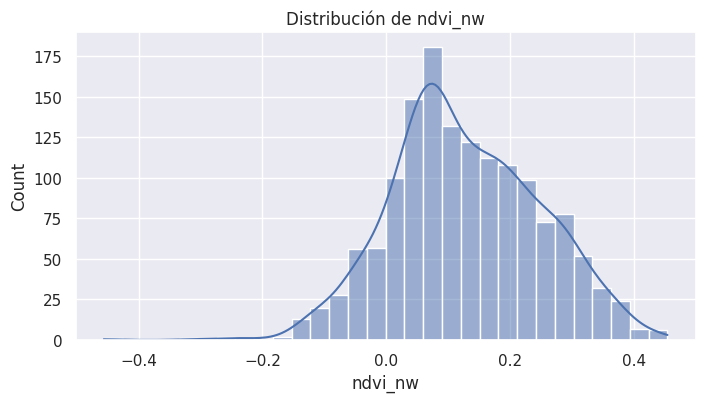

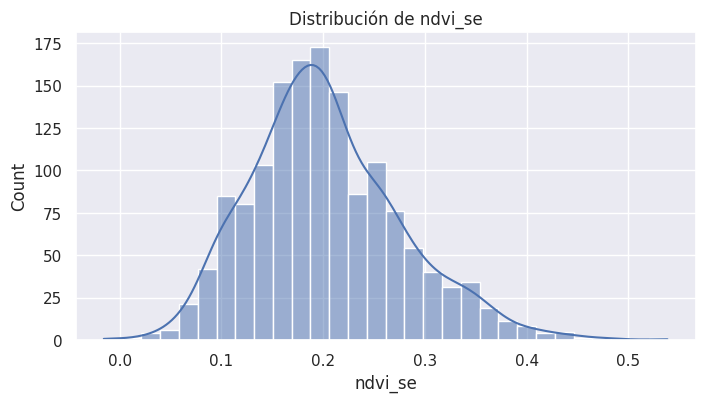

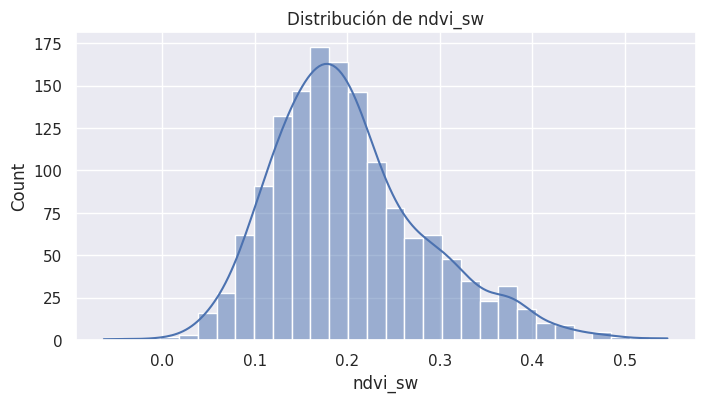

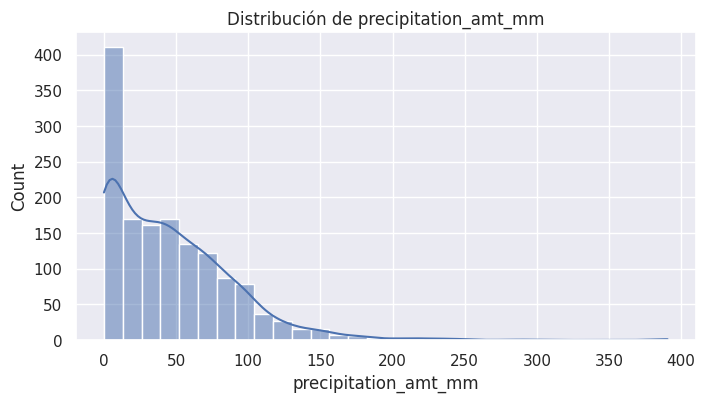

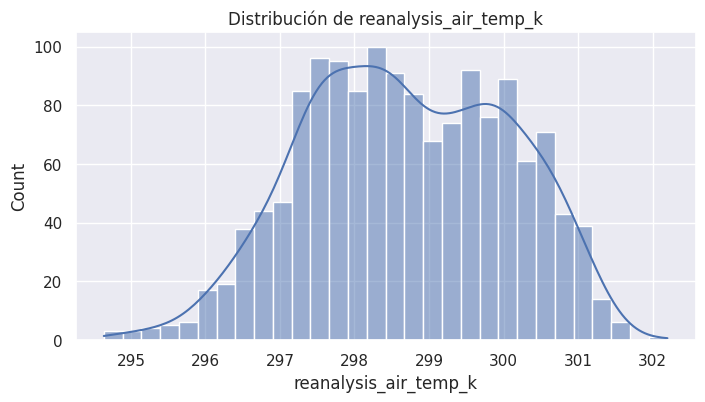

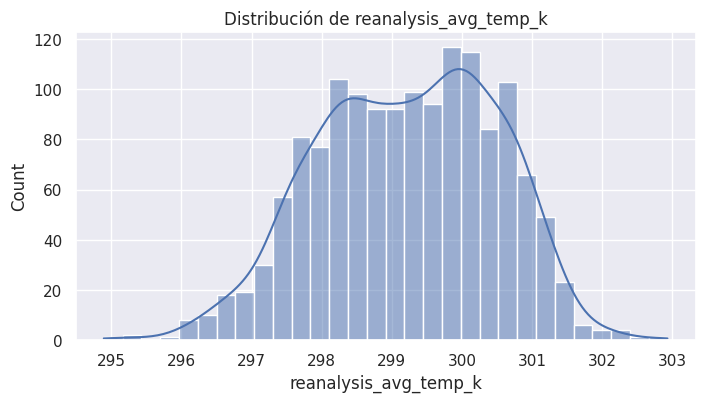

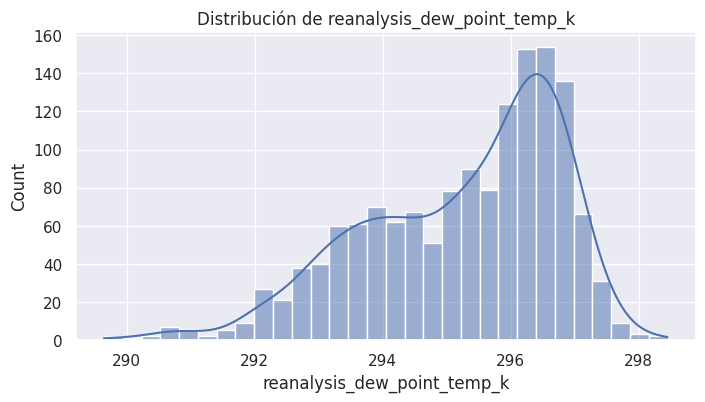

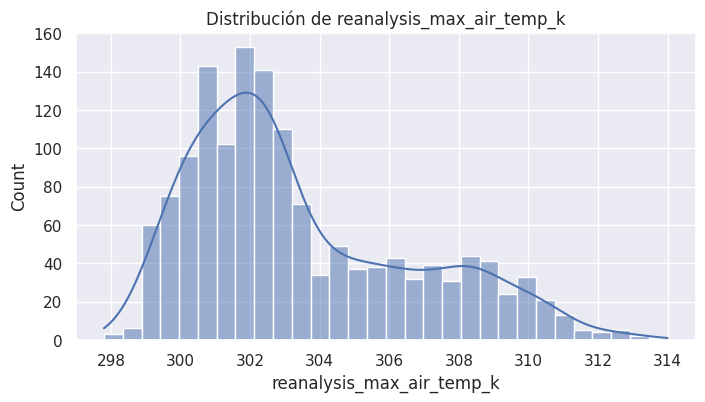

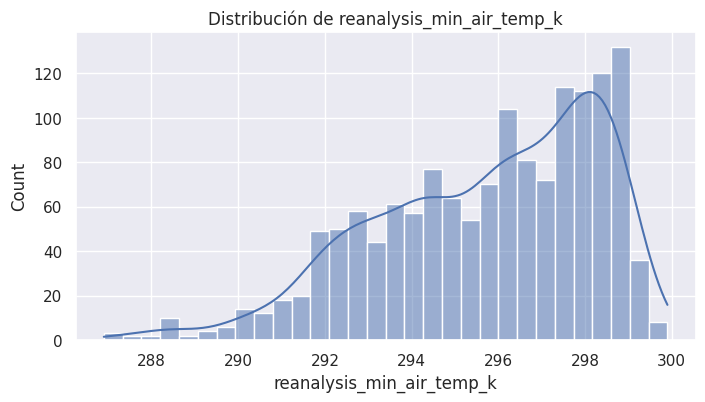

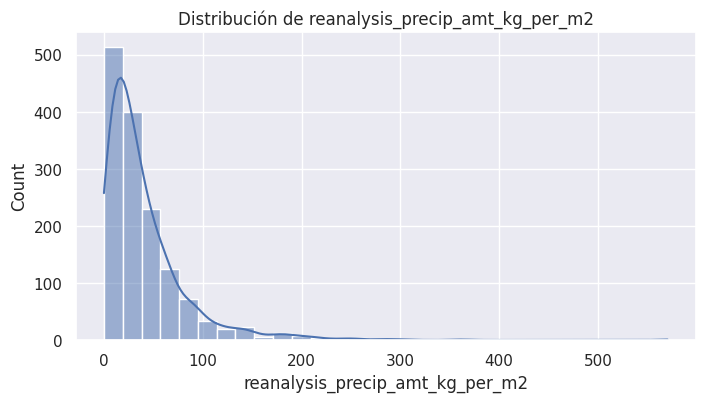

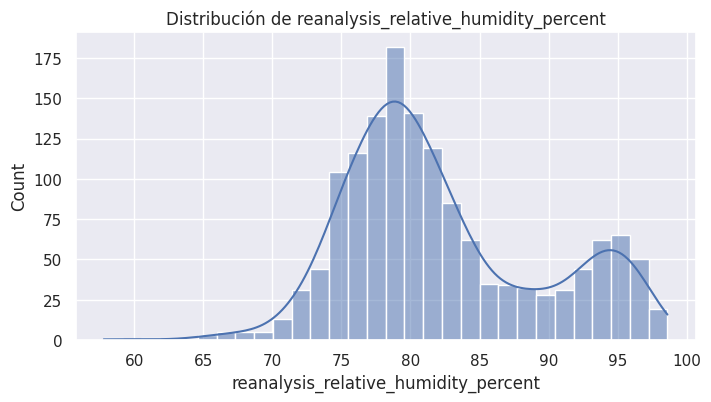

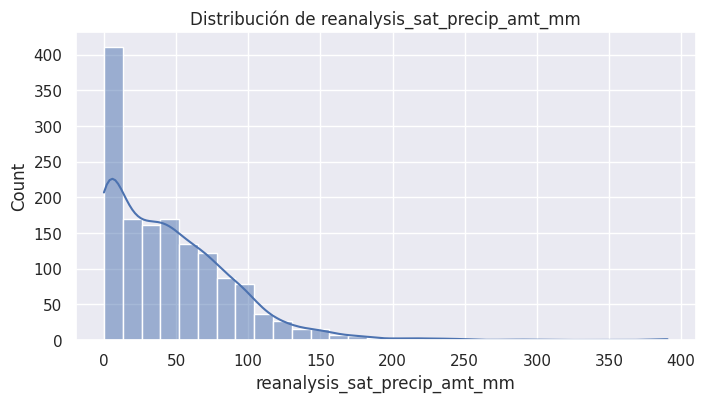

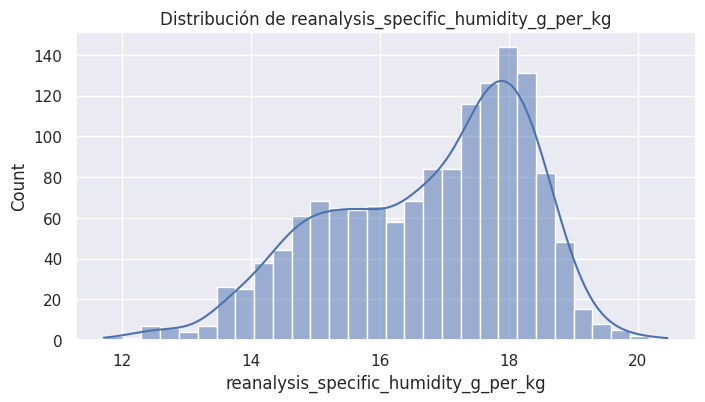

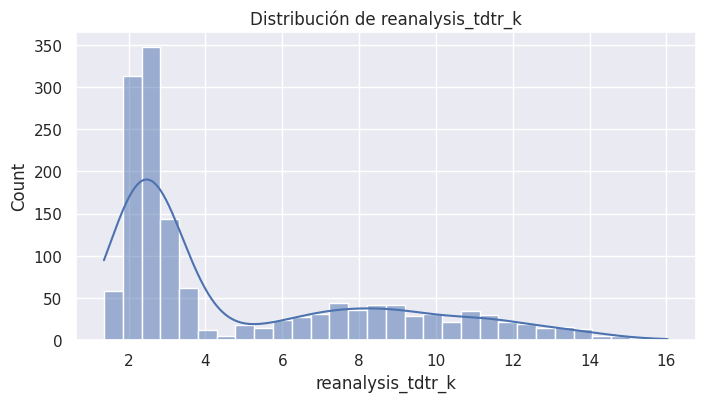

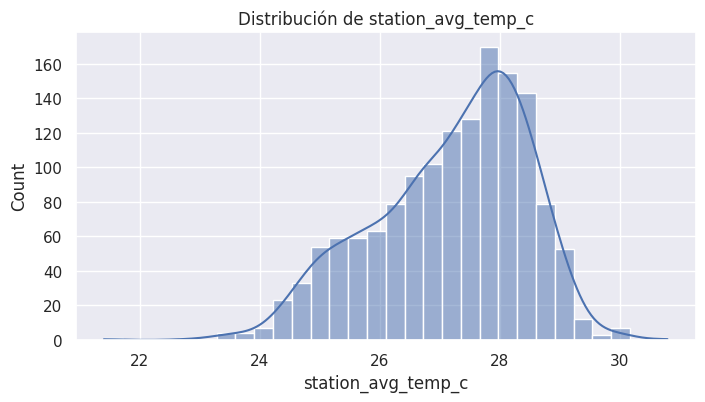

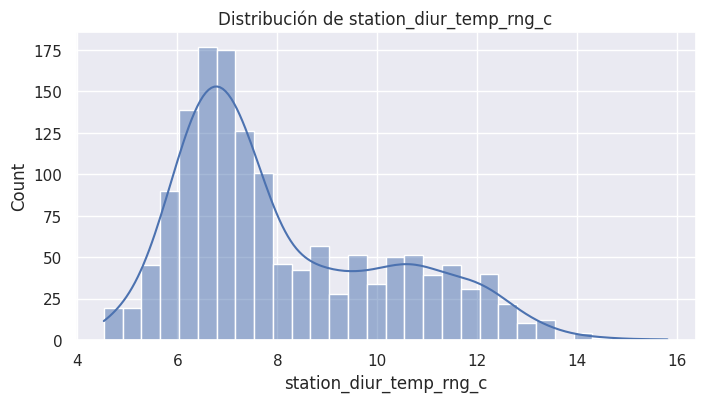

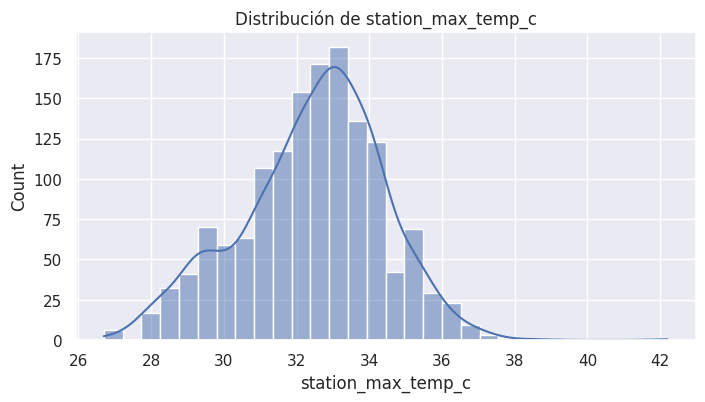

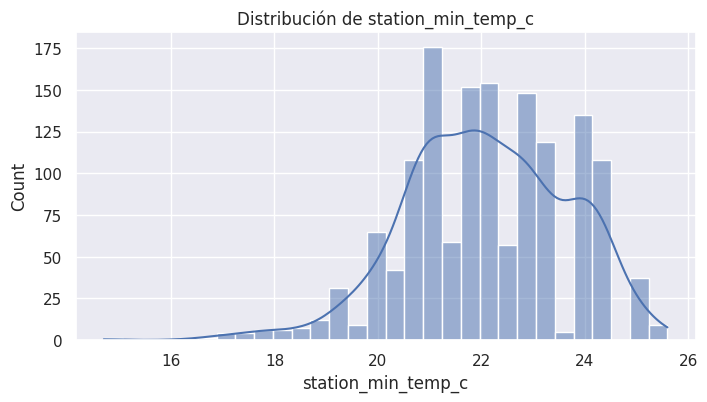

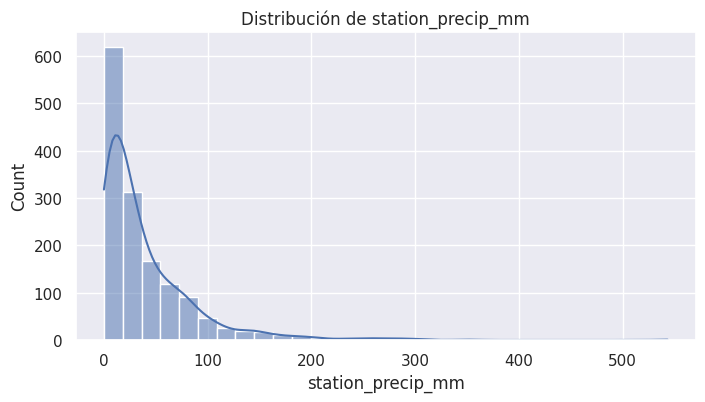

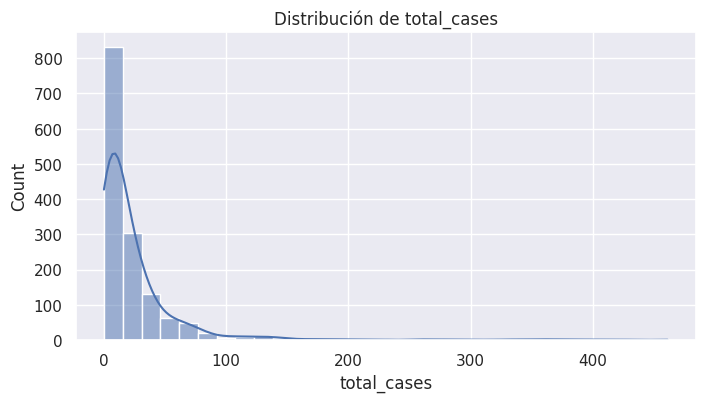

In [ ]:
# genero multiples graficos para las variables
columnas = ['year', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases']

for columna in columnas:
    plt.figure(figsize=(8,4))

    if data_f[columna].dtype in ['int64', 'float64']:  # Datos numéricos
        sns.histplot(data_f[columna], bins=30, kde=True)
    else:  # Datos categóricos
        sns.countplot(data=data_f, x=columna)

    plt.title(f'Distribución de {columna}')
    plt.show()

## ANALISIS BIVARIADO

##*relación de las variables con la Cantidad de Casos, por ciudad*

<Figure size 800x400 with 0 Axes>

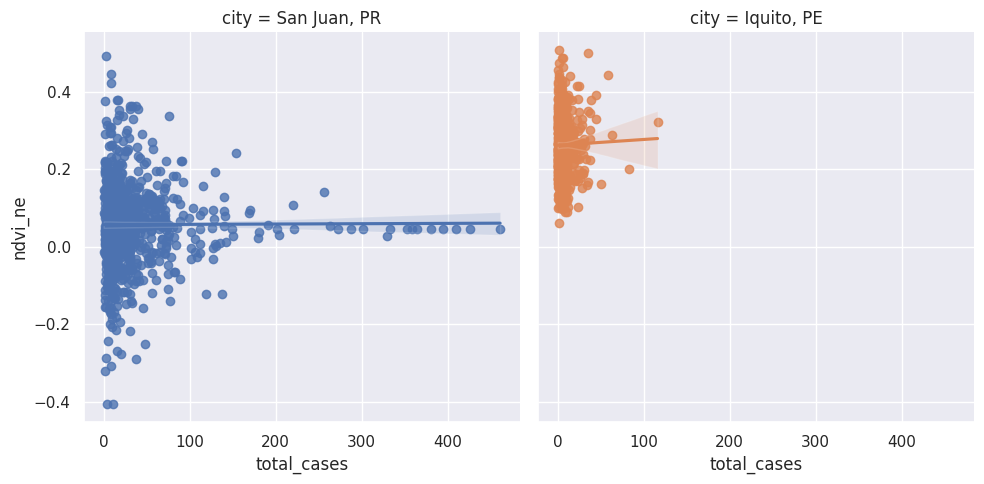

In [ ]:
plt.figure(figsize=(8,4))
sns.lmplot(data=data_f, x='total_cases', y='ndvi_ne', col='city', hue='city')

<Figure size 800x400 with 0 Axes>

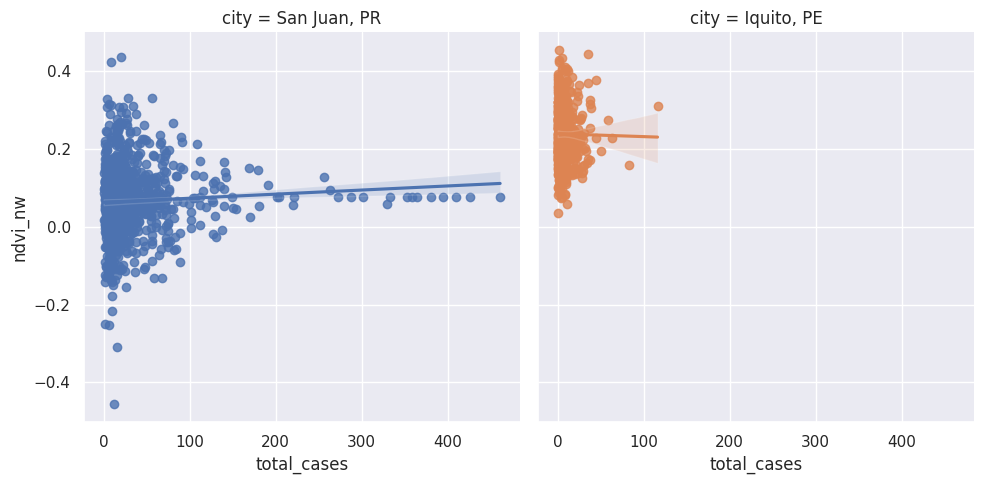

In [ ]:
plt.figure(figsize=(8,4))
sns.lmplot(data=data_f, x='total_cases', y='ndvi_nw', col='city', hue='city')

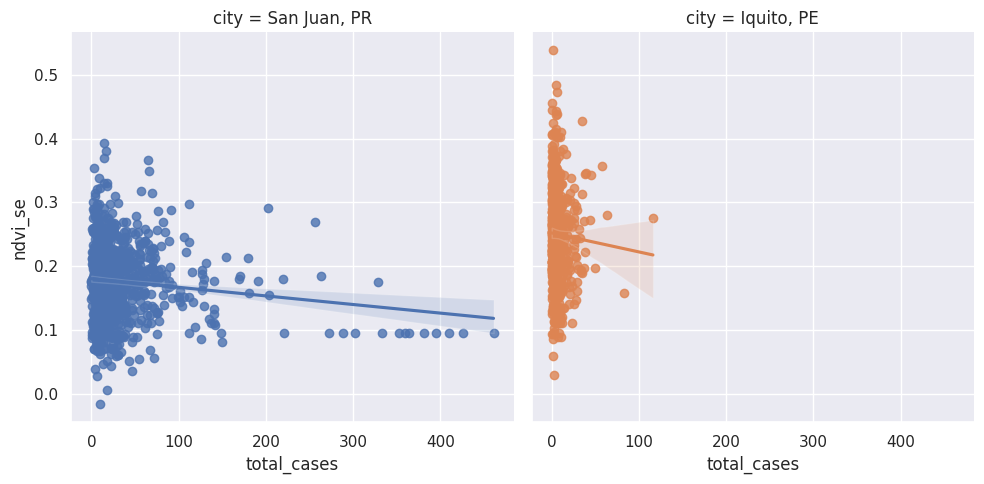

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='ndvi_se', col='city', hue='city')

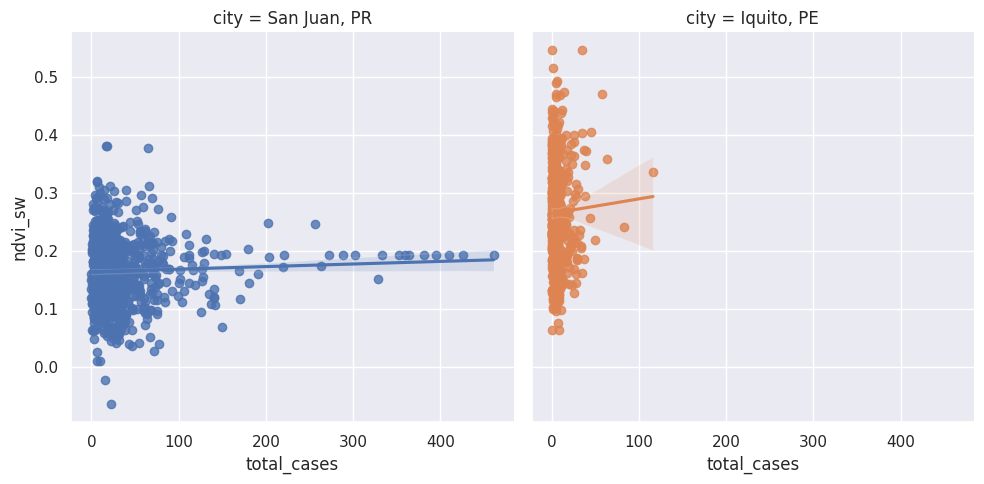

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='ndvi_sw', col='city', hue='city')

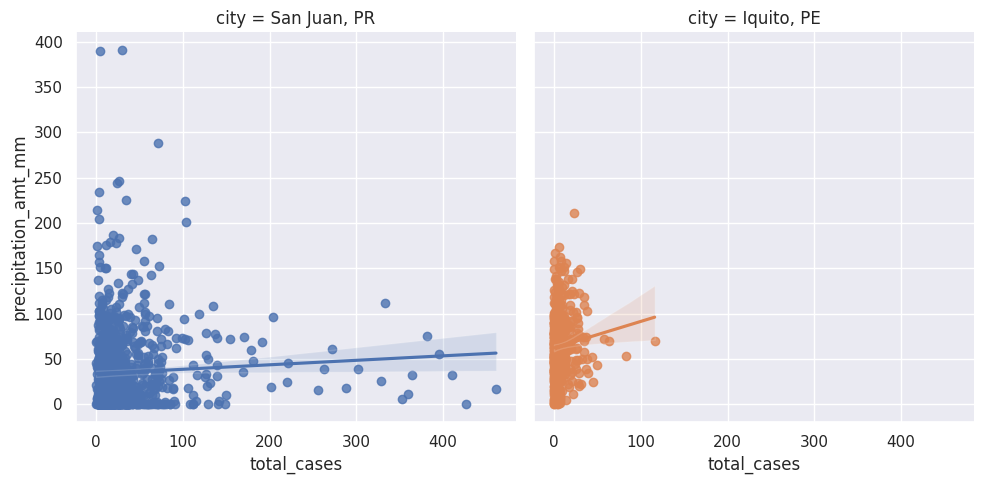

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='precipitation_amt_mm', col='city', hue='city')

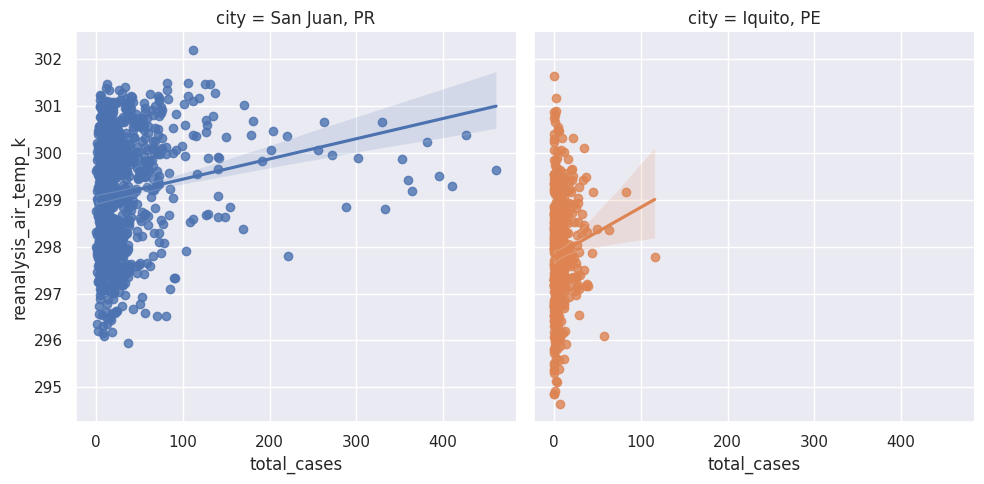

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_air_temp_k', col='city', hue='city')

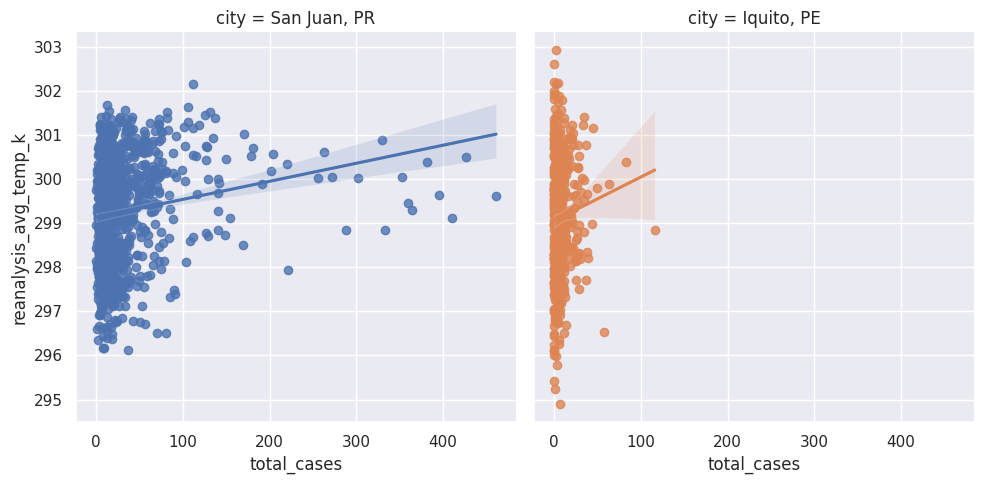

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_avg_temp_k', col='city', hue='city')

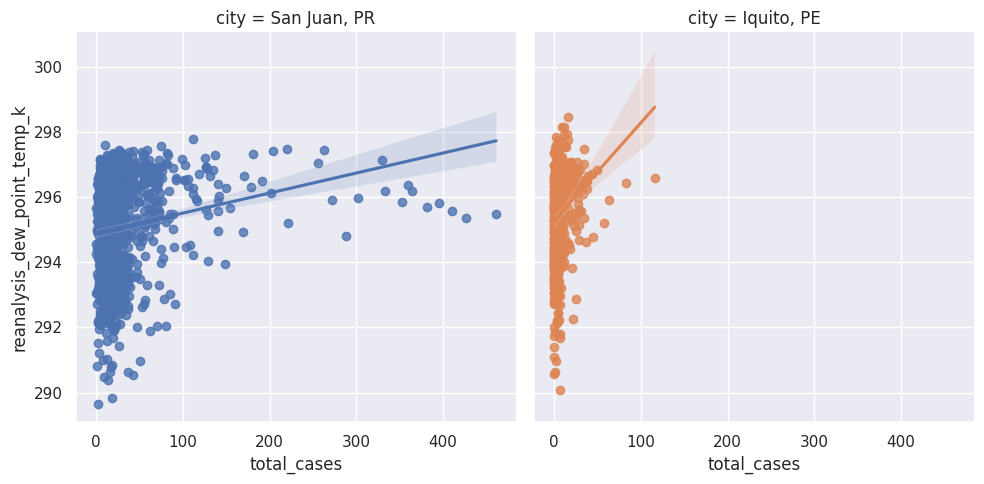

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_dew_point_temp_k', col='city', hue='city')

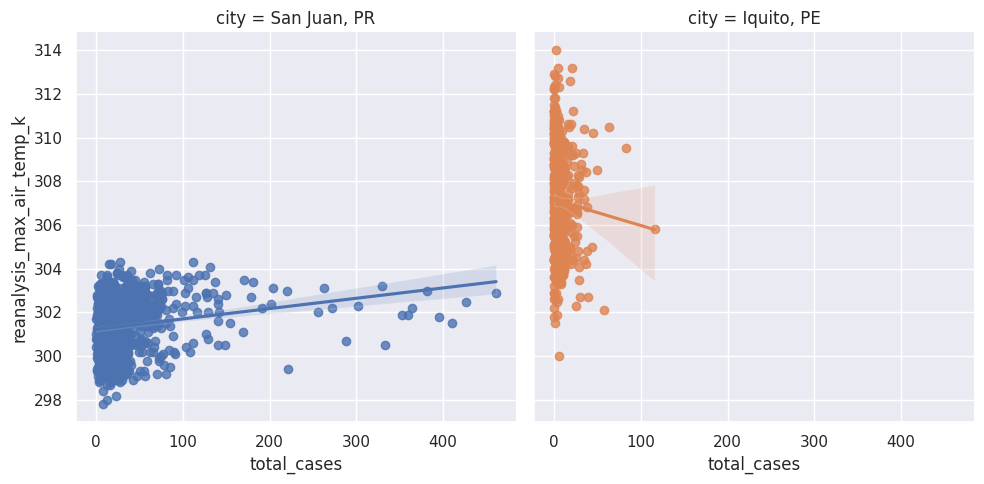

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_max_air_temp_k', col='city', hue='city')

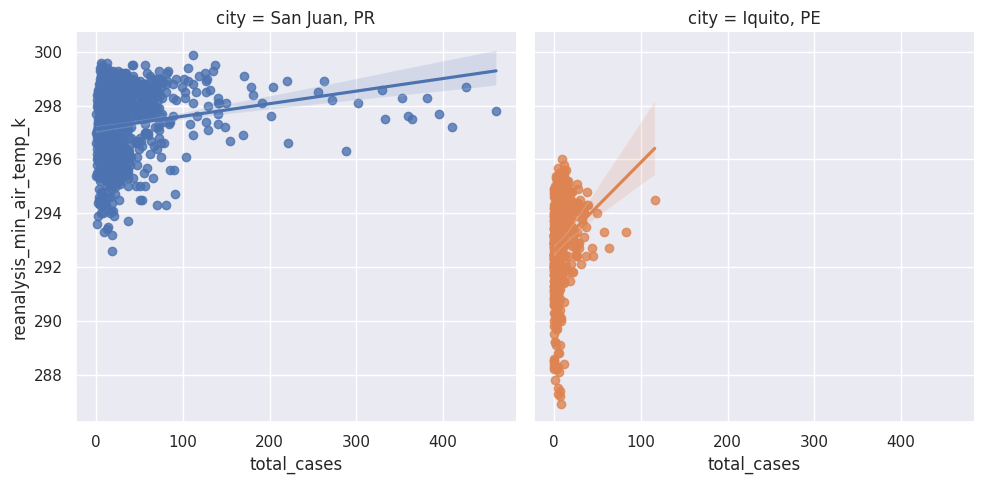

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_min_air_temp_k', col='city', hue='city')

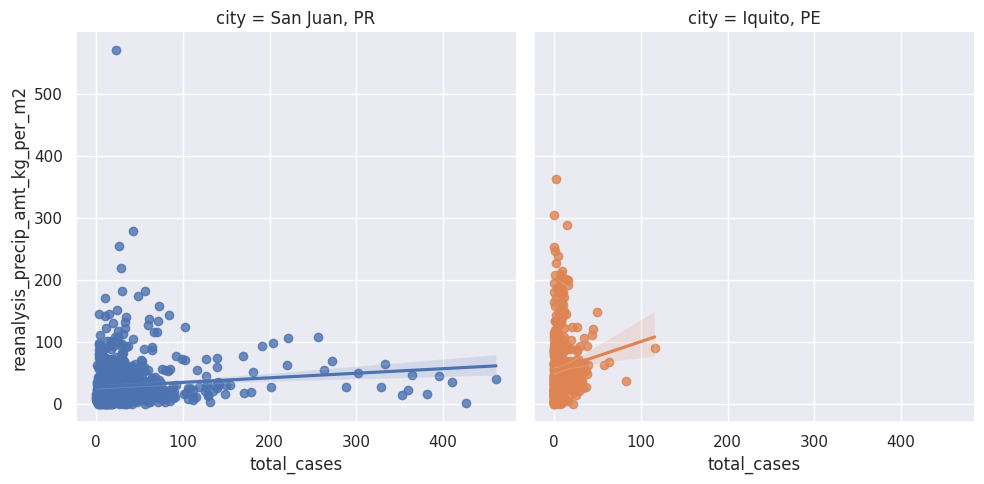

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_precip_amt_kg_per_m2', col='city', hue='city')

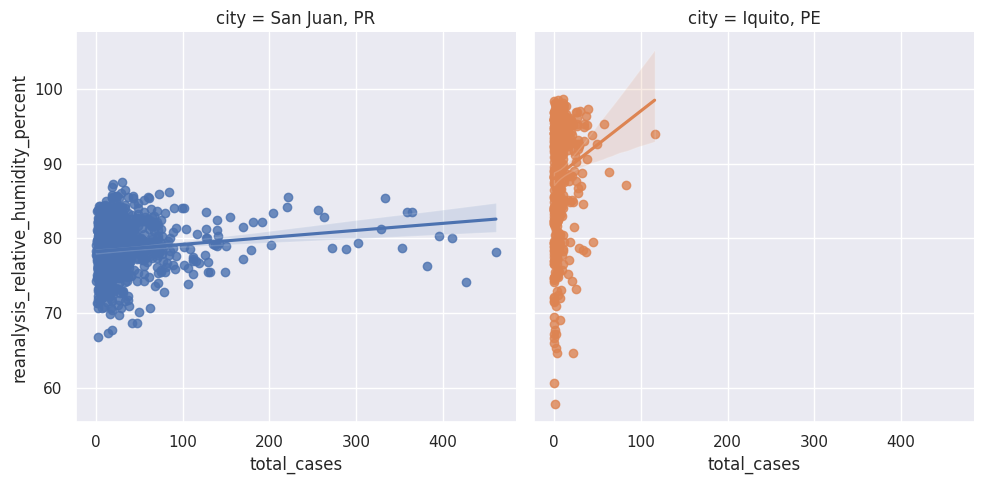

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_relative_humidity_percent', col='city', hue='city')

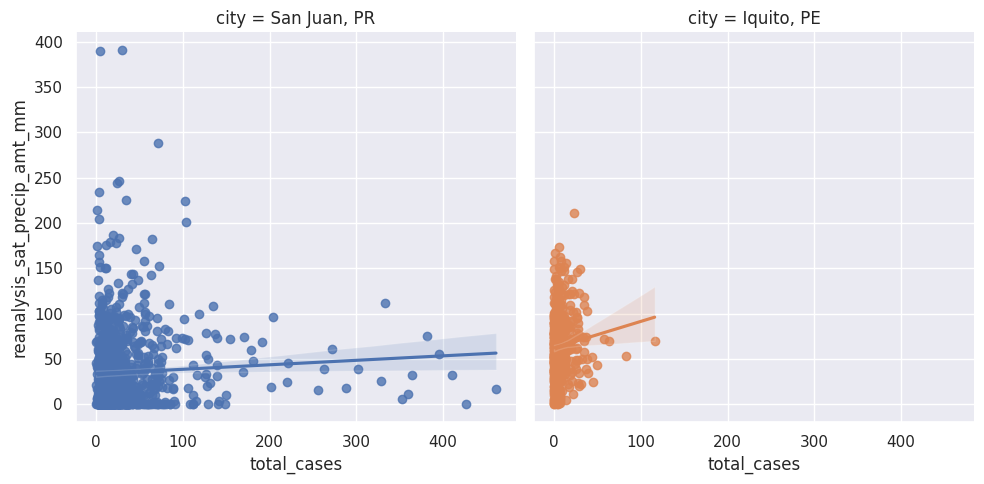

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_sat_precip_amt_mm', col='city', hue='city')

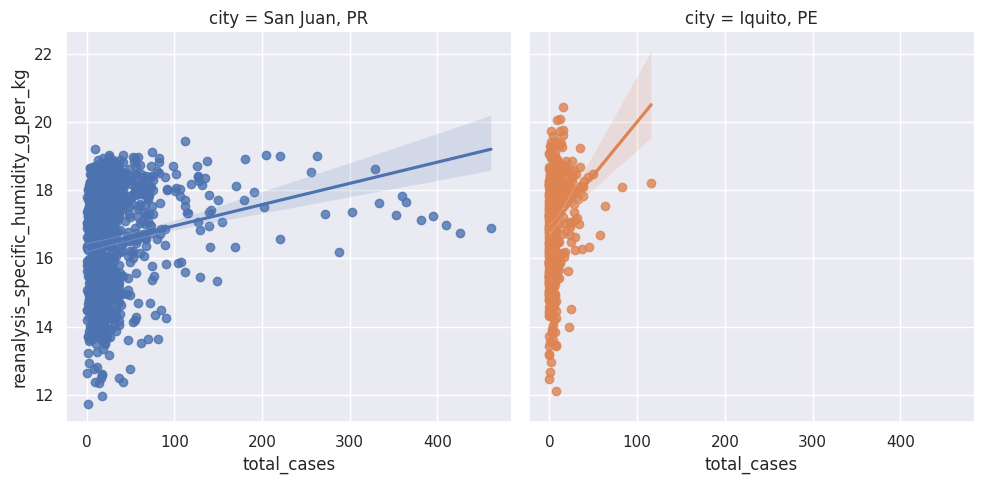

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_specific_humidity_g_per_kg', col='city', hue='city')

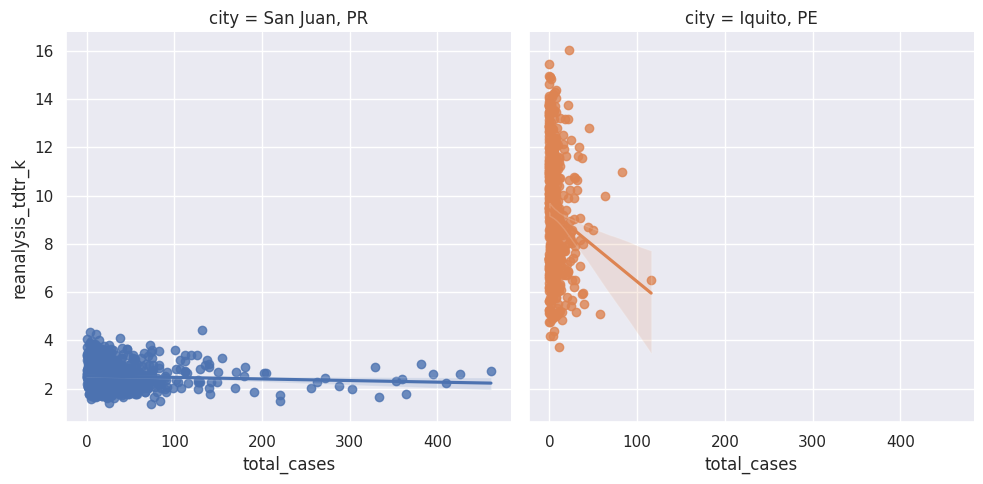

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_tdtr_k', col='city', hue='city')

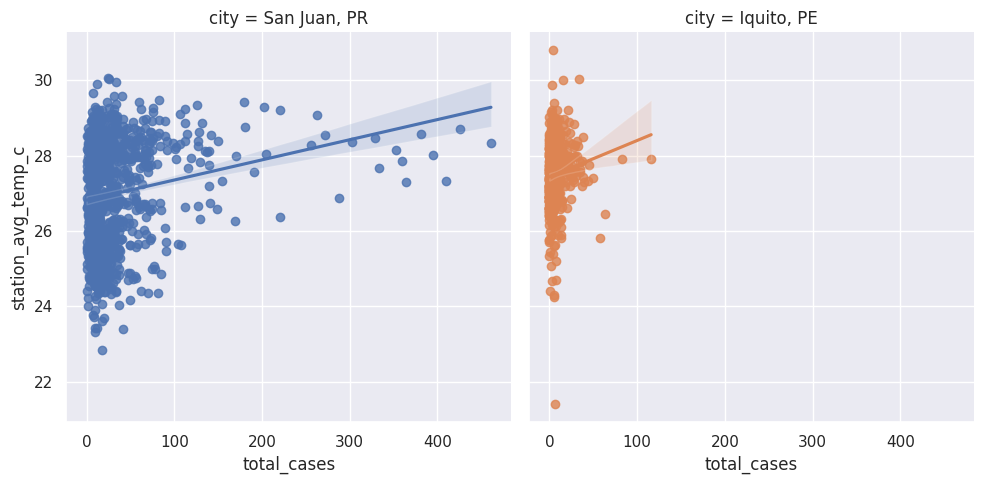

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='station_avg_temp_c', col='city', hue='city')

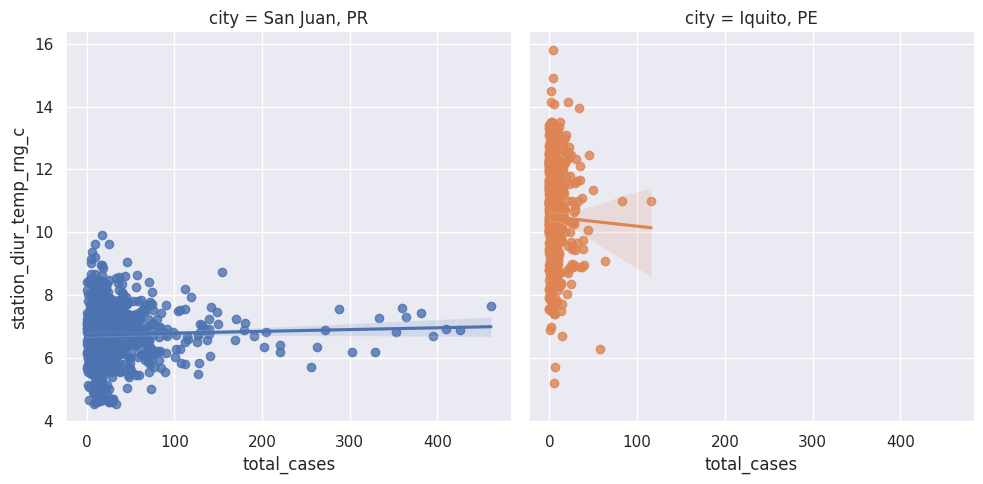

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='station_diur_temp_rng_c', col='city', hue='city')

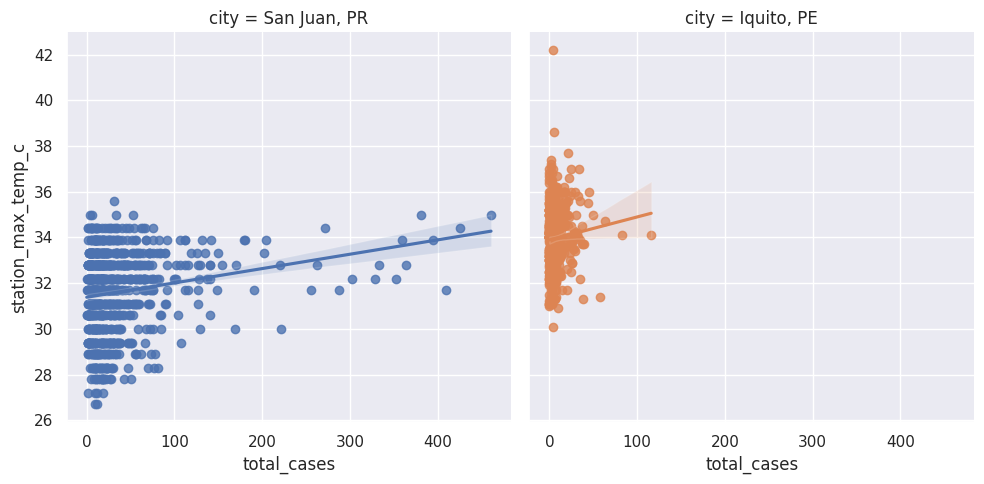

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='station_max_temp_c', col='city', hue='city')

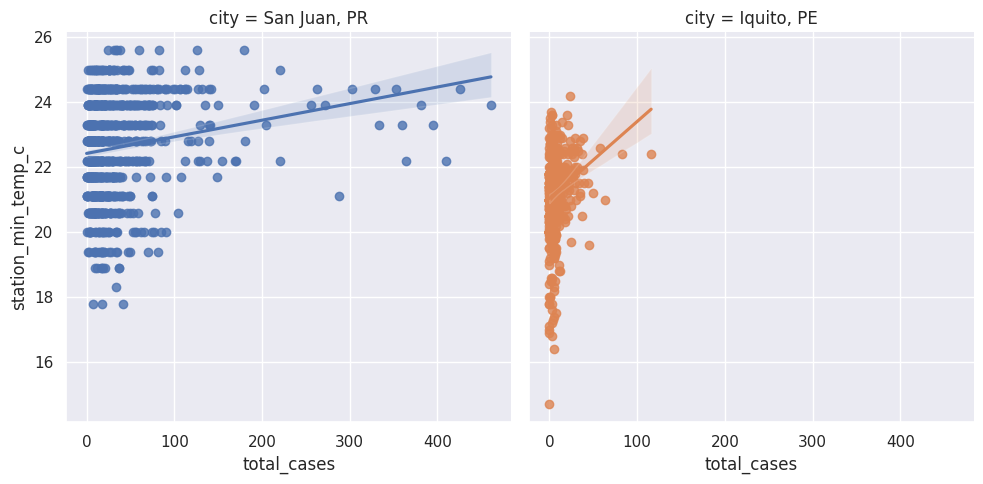

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='station_min_temp_c', col='city', hue='city')

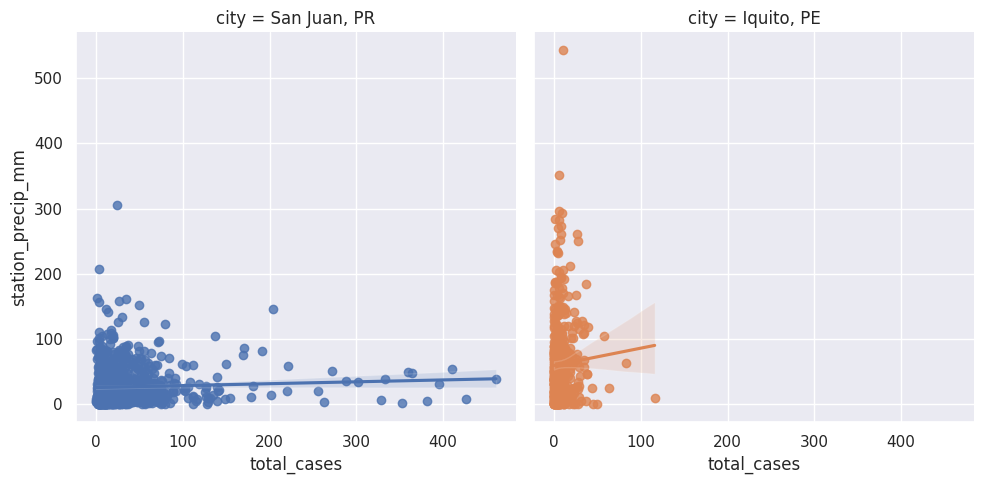

In [ ]:
sns.lmplot(data=data_f, x='total_cases', y='station_precip_mm', col='city', hue='city')

*Buscando - observando algunos INSIGHT*

In [ ]:
data_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1456 non-null   object        
 1   year                                   1456 non-null   int64         
 2   weekofyear                             1456 non-null   int64         
 3   week_start_date                        1456 non-null   datetime64[ns]
 4   ndvi_ne                                1456 non-null   float64       
 5   ndvi_nw                                1456 non-null   float64       
 6   ndvi_se                                1456 non-null   float64       
 7   ndvi_sw                                1456 non-null   float64       
 8   precipitation_amt_mm                   1456 non-null   float64       
 9   reanalysis_air_temp_k                  1456 non-null   float64 

# a) *Promedio total de casos por año*

In [ ]:
años_prom_datos = pd.DataFrame(data_f.groupby(['year']).mean())

<ipython-input-58-beb57ab78e28>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  años_prom_datos = pd.DataFrame(data_f.groupby(['year']).mean())


<Axes: xlabel='year', ylabel='total_cases'>

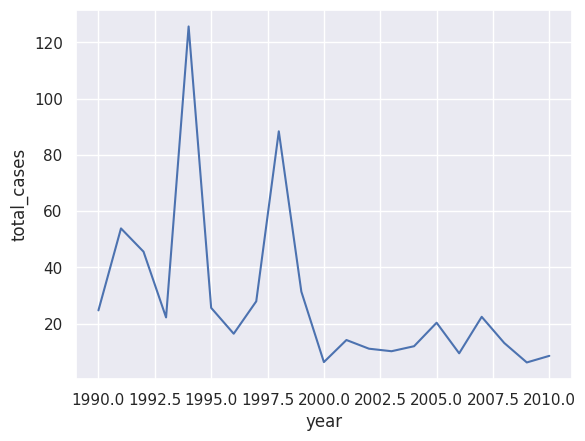

In [ ]:
sns.lineplot(data=años_prom_datos, x=años_prom_datos.index, y=años_prom_datos['total_cases'])

* se observa una disminución de los casos a lo de los años; con un pico significativo en el año 1993.

# b) *Promedio total de casos por semana*

In [ ]:
sem_prom_datos = pd.DataFrame(data_f.groupby(['weekofyear']).mean())

<ipython-input-60-9ac27124637c>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sem_prom_datos = pd.DataFrame(data_f.groupby(['weekofyear']).mean())


<Axes: xlabel='weekofyear', ylabel='total_cases'>

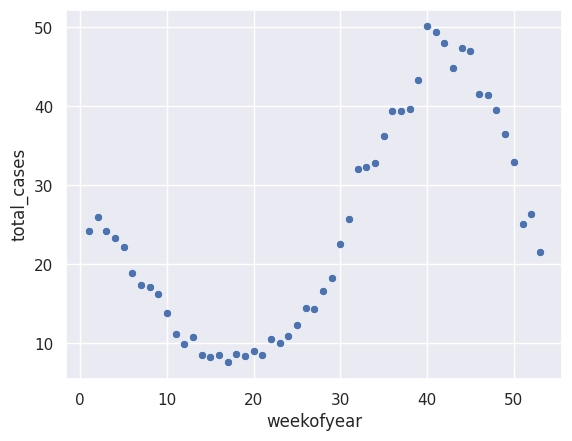

In [ ]:
sns.scatterplot(data=sem_prom_datos, x=sem_prom_datos.index, y=sem_prom_datos['total_cases'])

* en cuanto a los casos por semana; se observan picos en la semana 40; fines de septiembre - principios de octubre a lo largo de los años.

# c) *Total de casos por índice de vegetación (centroides)*


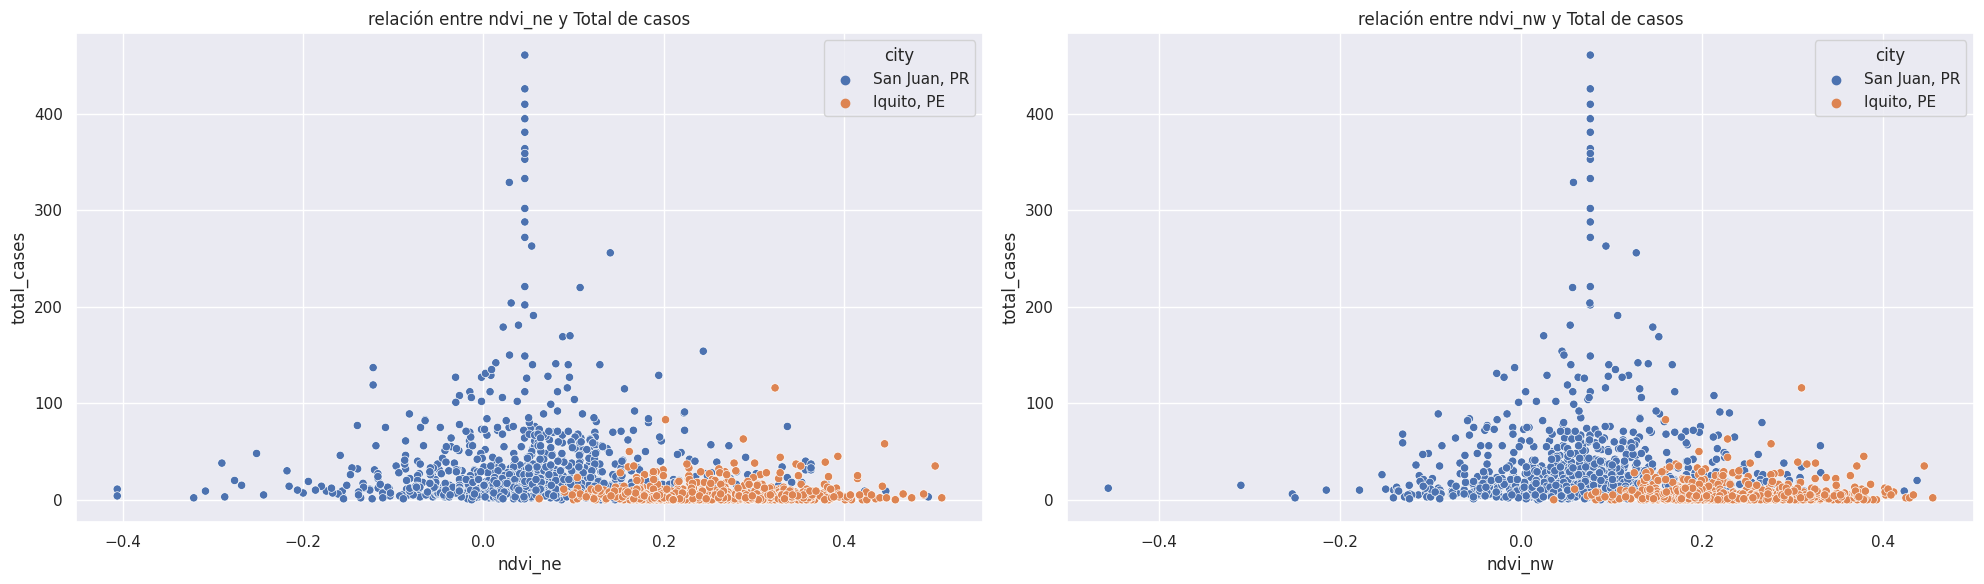

In [ ]:
#plt.figure(figsize=(8,4))
#sns.scatterplot(data=data_f, x='ndvi_ne', y='total_cases', hue='city')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
col2 = ['ndvi_ne', 'ndvi_nw']
for i, col in enumerate(col2):
  sns.scatterplot(data=data_f, x=col, y='total_cases', ax=axes[i], hue='city')
  axes[i].set_title(f'relación entre {col} y Total de casos')

plt.tight_layout() #ajusta parametros de los subgraficos para verlos mejor
plt.show()

## conclusión en razón del gráfico de arriba

# d) *Total de casos en relacion a la temperauras promedio*

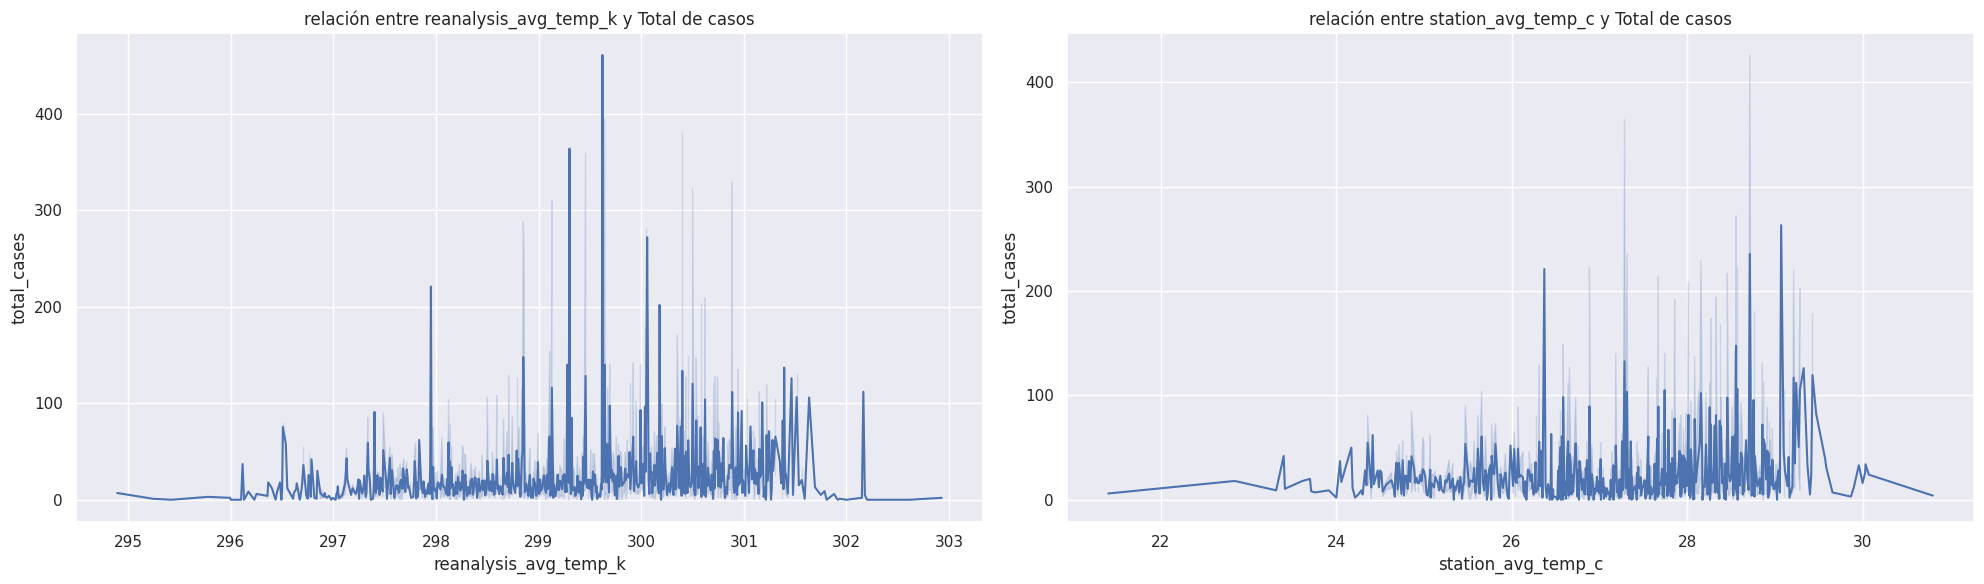

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
col2 = ['reanalysis_avg_temp_k', 'station_avg_temp_c']
for i, col in enumerate(col2):
  sns.lineplot(data=data_f, x=col, y='total_cases', ax=axes[i])
  axes[i].set_title(f'relación entre {col} y Total de casos')

plt.tight_layout() #ajusta parametros de los subgraficos para verlos mejor
plt.show()

* a mayor temperatura se incrementan los casos...

# e) *Total de casos en relación a la humedad*

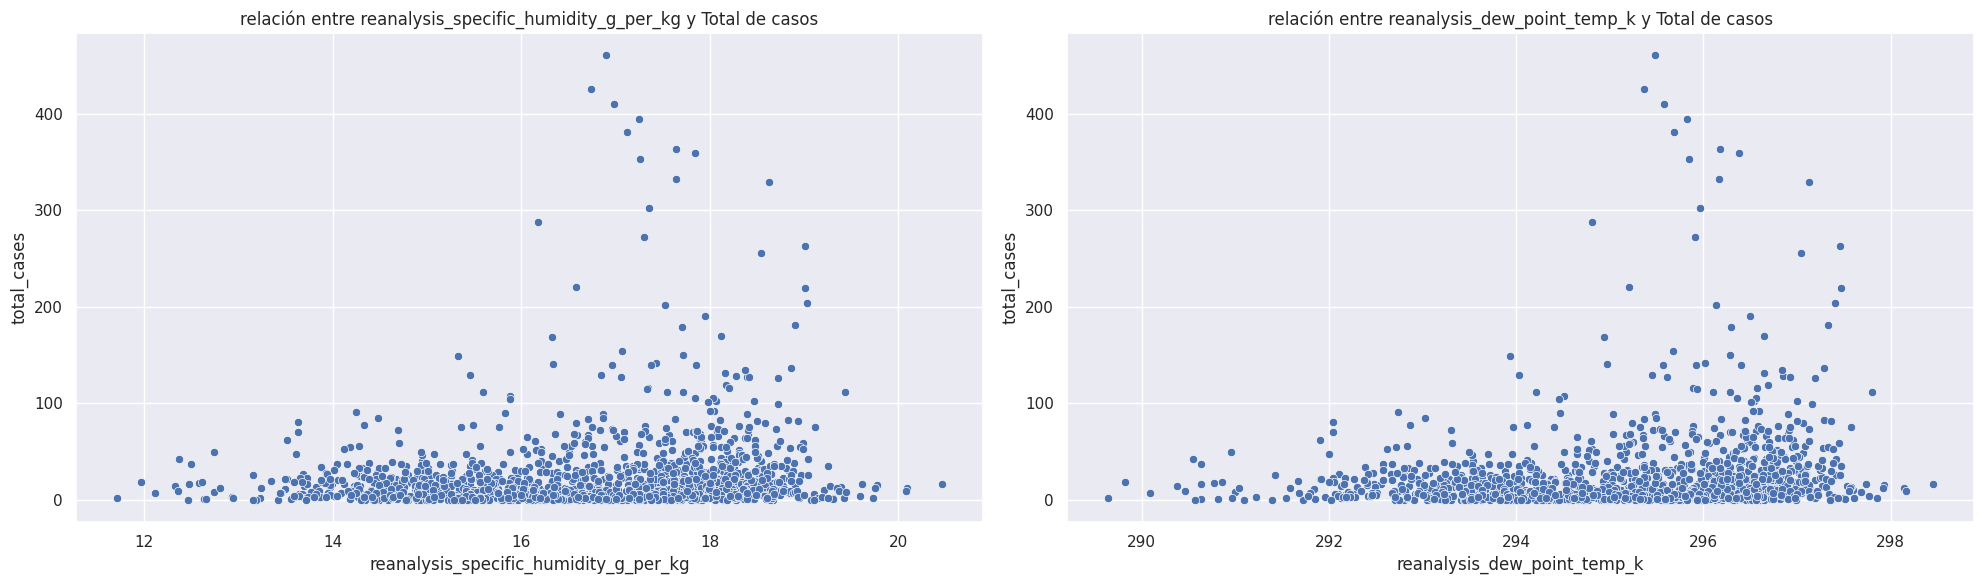

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
col2 = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k']
for i, col in enumerate(col2):
  sns.scatterplot(data=data_f, x=col, y='total_cases', ax=axes[i])
  axes[i].set_title(f'relación entre {col} y Total de casos')

plt.tight_layout() #ajusta parametros de los subgraficos para verlos mejor
plt.show()

* se observa, como seria lógico; que a mayor humedad mas cantidad de casos. El mosquito prospera en zonas húmedas.

# f) *Total de casos en relación a las precipitaciones*

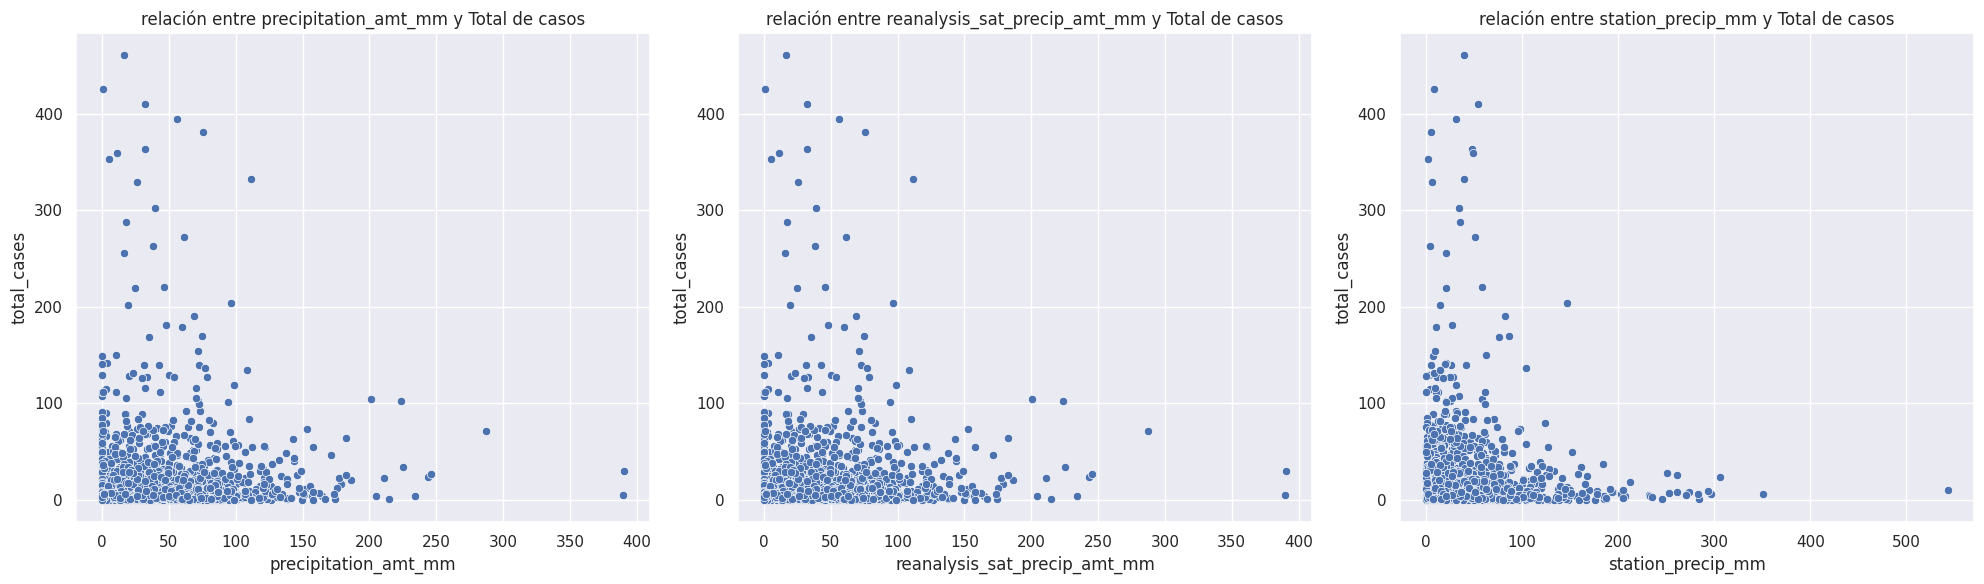

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
col2 = ['precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm']
for i, col in enumerate(col2):
  sns.scatterplot(data=data_f, x=col, y='total_cases', ax=axes[i])
  axes[i].set_title(f'relación entre {col} y Total de casos')

plt.tight_layout() #ajusta parametros de los subgraficos para verlos mejor
plt.show()

* pareciera (curiosamente), que las lluvias no producen un incremento de los casos

## ANALISIS MULTIVARIADO

*haremos análisis multivariados tomando grupos relacionadas con: temperaturas; vegentación; humedad y luego tomando todas las variables*

In [ ]:
# lista de todas las columnas
columnas

In [ ]:
# generando listas de columnas a analizar
temperaturas = ['station_avg_temp_c','station_max_temp_c','station_min_temp_c']
vegetacion = ['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']
humedad = ['reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent', 'reanalysis_dew_point_temp_k']

In [ ]:
data_f.info()

limitando a 2 compnentes

In [ ]:
#analisis de componetes principales (PCA)
X = data_f.iloc[:,4:-1] # todas las columnas menos las 4 primeras y la última
X = StandardScaler().fit_transform(X)

In [ ]:
# crear el objeto PCA y ajustar datos
pca = PCA(n_components=2)  # Reducir a 2 componentes
principalComponents = pca.fit_transform(X)

In [ ]:
# Crear un DataFrame con los componentes principales
principalDf = pd.DataFrame(data=principalComponents, columns=['CP1', 'CP2'])#, 'CP3','CP4'])

In [ ]:
principalDf.info()

In [ ]:
# cuanta varianza se explica por cada componete
var_explicada = pca.explained_variance_ratio_
print(f'Varianza explicada por cada componente: {var_explicada}')
print(f'Varianza Total explicada: {var_explicada.sum()}')

Varianza explicada por cada componente: [0.35256115 0.26546266]
Varianza Totl explicada: 0.6180238102304025


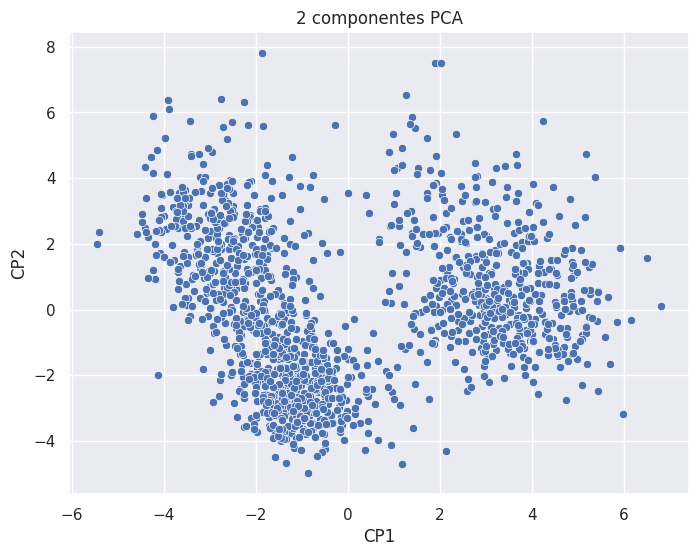

In [ ]:
# graficando los componentes
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='CP1',
    y='CP2',
    data=principalDf
)
plt.title('Todos para 2 componentes PCA')
plt.show()

*... sobre temperaturas*

In [ ]:
data_f[temperaturas]

In [ ]:
#analisis de componetes principales (PCA)
X = data_f[temperaturas] #
X = StandardScaler().fit_transform(X)

In [ ]:
# crear el objeto PCA y ajustar datos
pca = PCA(n_components=2)  # Reducir a 2 componentes
principalComponents = pca.fit_transform(X)

In [ ]:
# Crear un DataFrame con los componentes principales
principalDf = pd.DataFrame(data=principalComponents, columns=['CP1', 'CP2'])

In [ ]:
principalDf.info()

In [ ]:
# cuanta varianza se explica por cada componete
var_explicada = pca.explained_variance_ratio_
print(f'Varianza explicada por cada componente: {var_explicada}')
print(f'Varianza Total explicada: {var_explicada.sum()}')

Varianza explicada por cada componente: [0.68645635 0.28601513]
Varianza Totl explicada: 0.9724714826620551


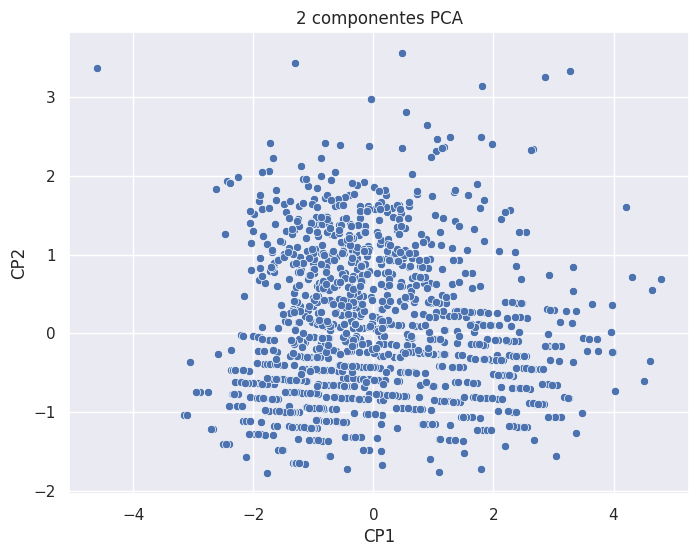

In [ ]:
# graficando los componentes principales - temperaturas
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='CP1',
    y='CP2',
    data=principalDf
)
plt.title('Temperatura 2 componentes PCA')
plt.show()

*... sobre vegetación*

In [ ]:
data_f[vegetacion]

In [ ]:
#analisis de componetes principales (PCA)
X = data_f[vegetacion] #
X = StandardScaler().fit_transform(X)

In [ ]:
# crear el objeto PCA y ajustar datos
pca = PCA(n_components=2)  # Reducir a 2 componentes
principalComponents = pca.fit_transform(X)

In [ ]:
# Crear un DataFrame con los componentes principales
principalDf = pd.DataFrame(data=principalComponents, columns=['CP1', 'CP2'])

In [ ]:
principalDf.info()

In [ ]:
# cuanta varianza se explica por cada componete
var_explicada = pca.explained_variance_ratio_
print(f'Varianza explicada por cada componente: {var_explicada}')
print(f'Varianza Total explicada: {var_explicada.sum()}')

Varianza explicada por cada componente: [0.75980443 0.1519179 ]
Varianza Total explicada: 0.9117223312037491


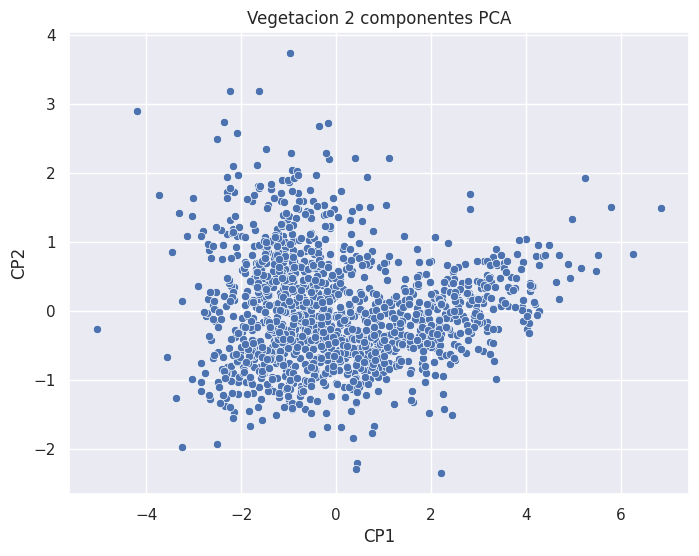

In [ ]:
# graficando los componentes principales - vegetacion
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='CP1',
    y='CP2',
    data=principalDf
)
plt.title('Vegetacion 2 componentes PCA')
plt.show()

*... sobre la humedad*

In [ ]:
data_f[humedad]

reanalysis_specific_humidity_g_per_kg  \
0                                 14.012857   
1                                 15.372857   
2                                 16.848571   
3                                 16.672857   
4                                 17.210000   
...                                     ...   
1451                              18.485714   
1452                              18.070000   
1453                              17.008571   
1454                              16.815714   
1455                              17.355714   

      reanalysis_relative_humidity_percent  reanalysis_dew_point_temp_k  
0                                73.365714                   292.414286  
1                                77.368571                   293.951429  
2                                82.052857                   295.434286  
3                                80.337143                   295.310000  
4                                80.460000                   295.821429  
...                                    ...                          ...  
1451                             88.765714                   296.825714  
1452                             91.600000                   296.452857  
1453                             94.280000                   295.501429  
1454                             94.660000                   295.324286  
1455                             89.082857                   295.807143  

[1456 rows x 3 columns]

In [ ]:
#analisis de componetes principales (PCA)
X = data_f[humedad] #
X = StandardScaler().fit_transform(X)

In [ ]:
# crear el objeto PCA y ajustar datos
pca = PCA(n_components=2)  # Reducir a 2 componentes
principalComponents = pca.fit_transform(X)

In [ ]:
# Crear un DataFrame con los componentes principales
principalDf = pd.DataFrame(data=principalComponents, columns=['CP1', 'CP2'])

In [ ]:
principalDf.info()

In [ ]:
# cuanta varianza se explica por cada componete
var_explicada = pca.explained_variance_ratio_
print(f'Varianza explicada por cada componente: {var_explicada}')
print(f'Varianza Total explicada: {var_explicada.sum()}')

Varianza explicada por cada componente: [0.81409543 0.18506289]
Varianza Total explicada: 0.9991583242342712


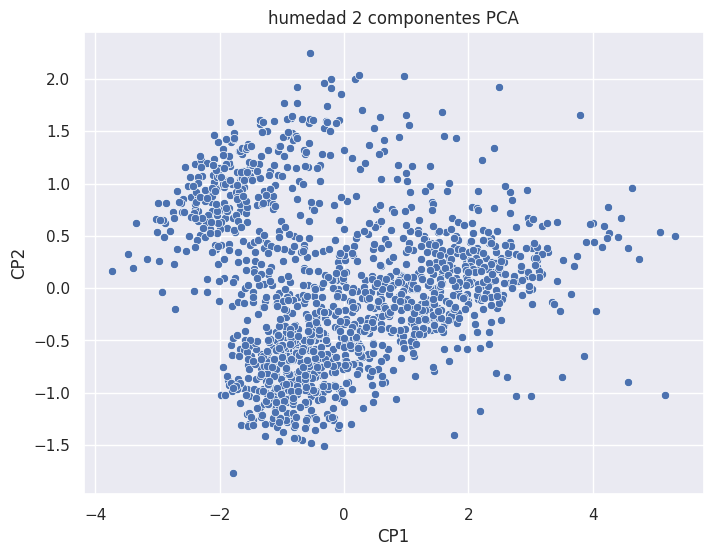

In [ ]:
# graficando los componentes principales - humedad
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='CP1',
    y='CP2',
    data=principalDf
)
plt.title('humedad 2 componentes PCA')
plt.show()

*... PCA sobre todos los componentes de dataframe*

sin limite de componentes para luego tomar los significativos

In [ ]:
#analisis de componetes principales (PCA)
X = data_f.iloc[:,4:-1] # todas las columnas menos las 4 primeras y la última
X = StandardScaler().fit_transform(X)

In [ ]:
# crear el objeto PCA y ajustar datos
pca = PCA()
principalComponents = pca.fit_transform(X)

In [ ]:
# Crear un DataFrame con los componentes principales
principalDf = pd.DataFrame(data=principalComponents, columns =['c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','c13','c14','c15','c16','c17','c18','c19','c20'])

1456

In [ ]:
principalDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   c1      1456 non-null   float64
 1   c2      1456 non-null   float64
 2   c3      1456 non-null   float64
 3   c4      1456 non-null   float64
 4   c5      1456 non-null   float64
 5   c6      1456 non-null   float64
 6   c7      1456 non-null   float64
 7   c8      1456 non-null   float64
 8   c9      1456 non-null   float64
 9   c10     1456 non-null   float64
 10  c11     1456 non-null   float64
 11  c12     1456 non-null   float64
 12  c13     1456 non-null   float64
 13  c14     1456 non-null   float64
 14  c15     1456 non-null   float64
 15  c16     1456 non-null   float64
 16  c17     1456 non-null   float64
 17  c18     1456 non-null   float64
 18  c19     1456 non-null   float64
 19  c20     1456 non-null   float64
dtypes: float64(20)
memory usage: 227.6 KB


In [ ]:
#cuanta varianza se explica por cada componete
var_explicada = pca.explained_variance_ratio_
print(f'Varianza explicada por cada componente: {var_explicada}')
print(f'Varianza Total explicada: {var_explicada.sum()}')

Varianza explicada por cada componente: [3.52561148e-01 2.65462662e-01 1.34495865e-01 5.80597140e-02
 5.04628197e-02 3.19810520e-02 2.70959796e-02 2.27674168e-02
 1.57062381e-02 1.21339899e-02 9.48929401e-03 7.80300334e-03
 4.70882539e-03 3.79645752e-03 1.77020729e-03 1.16503483e-03
 3.97188927e-04 9.45305208e-05 4.85728993e-05 1.13715347e-32]
Varianza Total explicada: 0.9999999999999999


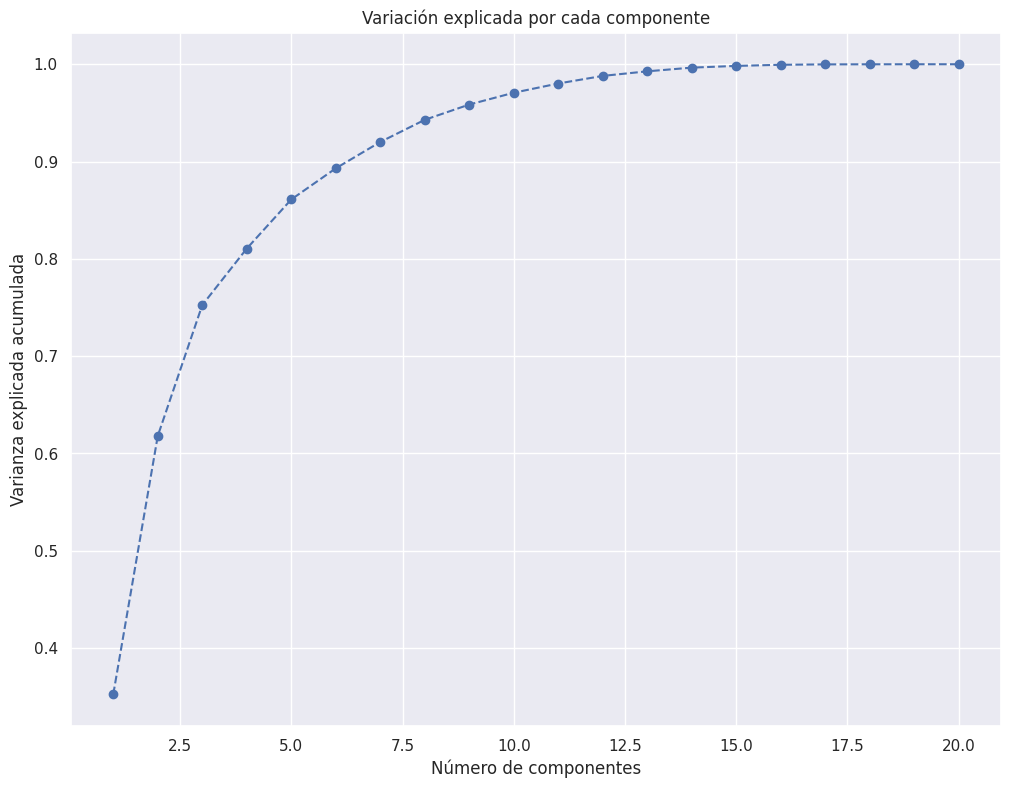

In [ ]:
n_compo = len(pca.explained_variance_ratio_)
plt.figure(figsize = (12,9))
plt.plot(range(1, n_compo + 1), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Variación explicada por cada componente')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.show()

### *de la variacion explicada y el "codo" de la grafica superior; y si tomaramos todos los las columnas, surge que la cantidad de componentes a utilizar en un analisis de clustering sería de 5*

## K-means

In [ ]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
principalDf['Cluster'] = kmeans.fit_predict(principalDf)
centroide = kmeans.cluster_centers_

# Ver los primeros datos con su cluster asignado
print(principalDf.head())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


         c1        c2        c3        c4        c5        c6        c7  \
0 -2.695136  3.338792  0.140263 -0.225769  0.473882 -0.269340  0.153103   
1 -1.916698  1.089376 -0.213002 -0.240862 -0.213863 -0.284420 -0.921736   
2 -1.518338 -0.397503  0.420351 -0.443131 -0.277715  0.226540 -0.599456   
3 -0.731515 -0.315347 -1.126219 -1.388771 -0.183149 -0.247514 -0.893580   
4  0.425749 -1.235069 -2.178198 -1.371607 -0.581952 -0.144944 -1.144545   

         c8        c9       c10  ...       c12       c13       c14       c15  \
0  0.801148  0.091525  0.243196  ... -0.022006 -0.222207  0.285092 -0.180511   
1  0.624907  0.144748 -0.168524  ...  0.063783  0.277878  0.079129 -0.154364   
2  0.079783 -0.002706  0.374211  ... -0.353367  0.313286 -0.258152  0.138173   
3  0.174419  0.342865  0.140543  ... -0.398891  0.474777 -0.175987  0.090571   
4  0.230927  1.066866  0.497956  ... -0.353507 -0.096266 -0.253146  0.195059   

        c16       c17       c18       c19           c20  Cluster  
0

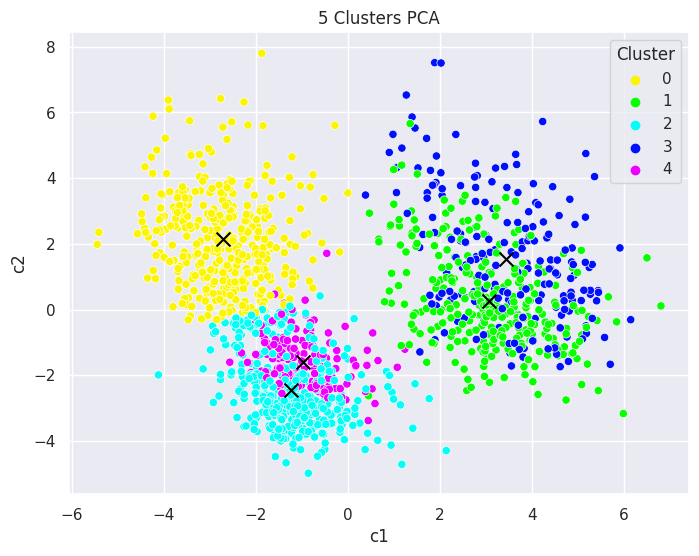

In [ ]:
#graficando los datos
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='c1',
    y='c2',
    hue='Cluster',  # Color por cluster
    palette=sns.color_palette('hsv', n_clusters),  # Colores
    data=principalDf,
    legend='full'
)
# Agregar los centroides al gráfico
plt.scatter(
    centroide[:, 0], centroide[:, 1],  # Coordenadas de los centroides
    marker='x',  # Forma de los centroides
    s=100,  # Tamaño de los centroides
    c='black'  # Color de los centroides
)

plt.title(f'{n_clusters} Clusters PCA')
plt.show()


hasta aqui llegue hoy 25/09/2023 - 19.22

### Análisis multivariado para predicción
ver clase 37 y continuar